# Predicting All-NBA Team and Player Salaries - Modeling Part I of II
---

In our modeling notebooks, we will build upon the groundwork laid by our webscraping, data cleaning, and exploratory data analysis. Our cleaned data now contains over 80 features, including player statistic (advanced, totals, and per-game), salary cap information, and team payroll data. With this, our objective is twofold:

1. <span style = 'color:orange'><u>**All-NBA Team**</u>:  First, in this notebook (Part I), we will ...</span>

    1. Construct multiple <u>**regression models**</u> to predict voter share, which will ultimately enable us to discern which Top 15 players made the All-NBA Teams (5 per 1st, 2nd, and 3rd Teams). The incentives for making any of the three teams (e.g., potential salary implications) are similar across all three teams. Therefore, we need only predict the Top 15, regardless of the exact team placement. By employing various regression techniques, we can gain valuable insights into the factors that influence the voters' decisions, helping us understand what distinguishes an All-NBA player from others. 
    
    2. Briefly employ <u>**classification models**</u> to determine how well our models perform in deciphering between 1st, 2nd, and 3rd team players. This involves inherent noise, as various external factors beyond statistics may come into play in determining the granular placement of a player once the top players are decided. The selection process considers aspects like preference for new talents, diversity in team composition, and subjective assessments of individual contributions to their teams. These intangible elements make the prediction task inherently challenging, and our model may not fully capture the complexities that influence the final team selections. Nevertheless, by leveraging available data and statistical analysis, we aim to provide valuable insights into player performance and potential team placement.
    
2. _<u>**Salary**</u>: Next, in [Part II](./05_Data_Modeling_II.ipynb), we will also use <u>**regression modeling**</u> to predict player salaries for the purpose of valuation, training on the intricate relationship between player performance, individual statistics, and their contracts._ 

This process will involve trial and error as well as the application of GridSearch techniques to fine-tune our models.

At the end of our analysis, we hope to unravel the complexities of the NBA landscape, discovering patterns and associations that govern player recognition in All-NBA Teams and their financial remuneration. These insights will inform decision-making processes and aid in the evaluation of player performance and compensation within the competitive realm of professional basketball.

Further detailed notebooks on the various segments of this project can be found at the following: 
- [01_Data_Acquisition](./01_Data_Acquisition.ipynb)
- [02_Data_Cleaning](./02_Data_Cleaning.ipynb)
- [03_Preliminary_EDA](./03_Preliminary_EDA.ipynb)
- [05_Data_Modeling_II](./05_Data_Modeling_II.ipynb)

For more information on the background, a summary of methods, and findings, please see the associated [README](../README.md) for this analysis.

## Contents
- [**1. Regression: Predicting Top 15 Players Using Voter Share**](#1.-Regression:-Predicting-Top-15-Players-Using-Voter-Share)
    - [Preliminaries](#Preliminaries)
        - [Null Models](#Null-Model-1)
        - [Average Precision Error Metric: Optimal for Ranking Data](#Average-Precision-Error-Metric:-Optimal-for-Ranking-Data)
    - [I. Support Vector Regression](#I.-Support-Vector-Regression)
    - [II. Random Forest Regressor](#II.-Random-Forest-Regressor)
    - [III. Elastic Net](#III.-Elastic-Net)
    - [IV. Extra Trees Regressor](#IV.-Extra-Trees-Regressor)
    - [V. Extreme Gradient Boosting Regressor](#V.-Extreme-Gradient-Boosting-Regressor)
    - [VI. Gradient Boosting Regressor](VI.-Gradient-Boosting-Regressor)
    - [VII. AdaBoost Regressor](VII.-AdaBoost-Regressor)
    - [VIII. Light Gradient Boosting Regressor](#VIII.-Light-Gradient-Boosting-Regressor)
- [**2. Classification: Predicting 1st, 2nd, 3rd Teams**](#2.-Classification:-Predicting-1st,-2nd,-3rd-Teams)
    - [Multiclass Classification](#Multiclass-Classification)
        - [IV. Logistic Regression](#IV.-Logistic-Regression)
        - [X. Support Vector Classification](#X.-Support-Vector-Classification)
        - [XI. Random Forest Classification](#XI.-Random-Forest-Classification)
    - [Binary Classification](#Binary-Classification)
---

In [1]:
# pip install xgboost

In [2]:
# pip install lightgbm

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_auc_score

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNet, LogisticRegression
from sklearn.svm import LinearSVR, SVR, SVC
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor, VotingRegressor, AdaBoostRegressor, GradientBoostingRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# from sklearn.neighbors import KNeighborsClassifier

import datetime
import warnings
warnings.filterwarnings('ignore') 

pd.options.display.max_rows = 400
pd.options.display.max_columns = 400

In [4]:
df = pd.read_csv('../data/clean/stats_main.csv')
df.head()

,player,pos,age,tm,g,pg_gs,pg_mp,pg_fg,pg_fga,pg_fg%,pg_3p,pg_3pa,pg_3p%,pg_2p,pg_2pa,pg_2p%,pg_efg%,pg_ft,pg_fta,pg_ft%,pg_orb,pg_drb,pg_trb,pg_ast,pg_stl,pg_blk,pg_tov,pg_pf,pg_pts,year,tot_gs,tot_mp,tot_fg,tot_fga,tot_fg%,tot_3p,tot_3pa,tot_3p%,tot_2p,tot_2pa,tot_2p%,tot_efg%,tot_ft,tot_fta,tot_ft%,tot_orb,tot_drb,tot_trb,tot_ast,tot_stl,tot_blk,tot_tov,tot_pf,tot_pts,adv_per,adv_ts%,adv_3par,adv_ftr,adv_orb%,adv_drb%,adv_trb%,adv_ast%,adv_stl%,adv_blk%,adv_tov%,adv_usg%,adv_ows,adv_dws,adv_ws,adv_ws/48,adv_obpm,adv_dbpm,adv_bpm,adv_vorp,gt1_pos,pos_5,pos_3,f,gu,midseason_trade,all_nba_team,pts_won,pts_max,share,all_nba_winner,draft_year,overall_pick,career_length,n_allstar,all_star,salary,salary_adj,team,conf,div,w,l,w/l%,seed,champs,won_championship,salary_cap,salary_cap_adj,payroll,payroll_adj
0,Nick Anderson,SG,23,ORL,70,42.0,28,5.7,12.2,0.467,0.2,0.8,0.293,5.5,11.4,0.479,0.477,2.5,3.7,0.668,1.3,4.2,5.5,1.5,1.1,0.6,1.6,2.1,14.1,1990,42.0,1971,400.0,857.0,0.467,17.0,58.0,0.293,383.0,799.0,0.479,0.477,173.0,259.0,0.668,92.0,294.0,386.0,106.0,74.0,44.0,113.0,145.0,990.0,15.1,0.510,0.068,0.302,4.9,16.7,10.7,8.5,1.8,1.3,10.4,22.4,1.2,1.9,3.1,0.075,0.0,0.3,0.3,1.1,0,SG,Gu,0,1,0,0,0.0,0.0,0.0,0.0,1989.0,11.0,1.0,0.0,0,725000.0,1653775.0,Orlando Magic,W,M,31,51,0.378,19,Chicago Bulls,0,11871000.0,25499592.0,7532000.0,17181014.0
1,Ron Anderson,SF,32,PHI,82,13.0,28,6.2,12.9,0.485,0.1,0.5,0.209,6.1,12.3,0.497,0.490,2.0,2.4,0.833,1.3,3.2,4.5,1.4,0.8,0.2,1.2,2.0,14.6,1990,13.0,2340,512.0,1055.0,0.485,9.0,43.0,0.209,503.0,1012.0,0.497,0.490,165.0,198.0,0.833,103.0,264.0,367.0,115.0,65.0,13.0,100.0,163.0,1198.0,15.5,0.524,0.041,0.188,5.0,12.4,8.8,8.2,1.4,0.3,8.1,23.2,2.3,1.8,4.1,0.085,-0.2,-1.4,-1.6,0.2,0,SF,F,1,0,0,0,0.0,0.0,0.0,0.0,1984.0,27.0,6.0,0.0,0,425000.0,969454.0,Philadelphia 76ers,E,A,44,38,0.537,12,Chicago Bulls,0,11871000.0,25499592.0,11640000.0,26551652.0
2,Willie Anderson,SG,24,SAS,75,75.0,34,6.0,13.2,0.457,0.1,0.5,0.200,5.9,12.7,0.467,0.461,2.3,2.8,0.798,0.9,3.8,4.7,4.8,1.1,0.6,2.2,3.0,14.4,1990,75.0,2592,453.0,991.0,0.457,7.0,35.0,0.200,446.0,956.0,0.467,0.461,170.0,213.0,0.798,68.0,283.0,351.0,358.0,79.0,46.0,167.0,226.0,1083.0,13.0,0.499,0.035,0.215,3.1,11.5,7.5,20.2,1.5,1.1,13.3,20.1,1.3,3.5,4.8,0.089,-0.9,1.0,0.1,1.4,0,SG,Gu,0,1,0,0,0.0,0.0,0.0,0.0,1988.0,10.0,2.0,0.0,0,725000.0,1653775.0,San Antonio Spurs,W,M,55,27,0.671,6,Chicago Bulls,0,11871000.0,25499592.0,11057000.0,25221786.0
3,Thurl Bailey,PF,29,UTA,82,22.0,30,4.9,10.6,0.458,0.0,0.0,0.000,4.9,10.6,0.459,0.458,2.7,3.3,0.808,1.2,3.7,5.0,1.5,0.6,1.1,1.6,2.0,12.4,1990,22.0,2486,399.0,872.0,0.458,0.0,3.0,0.000,399.0,869.0,0.459,0.458,219.0,271.0,0.808,101.0,306.0,407.0,124.0,53.0,91.0,130.0,160.0,1017.0,12.5,0.513,0.003,0.311,5.1,13.6,9.6,7.7,1.1,2.3,11.6,20.0,0.6,3.1,3.7,0.072,-1.4,0.0,-1.4,0.4,0,PF,F,1,0,0,0,0.0,0.0,0.0,0.0,1983.0,7.0,7.0,0.0,0,1000000.0,2281070.0,Utah Jazz,W,M,54,28,0.659,7,Chicago Bulls,0,11871000.0,25499592.0,10695000.0,24396040.0
4,Benoit Benjamin,C,26,LAC,70,65.0,31,5.5,11.1,0.496,0.0,0.0,0.000,5.5,11.1,0.496,0.496,3.0,4.2,0.712,2.2,8.1,10.3,1.7,0.8,2.1,3.4,2.6,14.0,1990,65.0,2236,386.0,778.0,0.496,0.0,0.0,0.000,386.0,778.0,0.496,0.496,210.0,295.0,0.712,157.0,566.0,723.0,119.0,54.0,145.0,235.0,184.0,982.0,15.1,0.541,0.000,0.379,7.8,28.7,18.1,7.7,1.2,4.0,20.6,21.0,-0.7,3.7,3.0,0.064,-1.9,0.8,-1.1,0.5,0,C,C,0,0,1,0,0.0,0.0,0.0,0.0,1985.0,3.0,5.0,0.0,0,1750000.0,3991872.0,Los Angeles Clippers,W,P,31,51,0.378,18,Chicago Bulls,0,11871000.0,25499592.0,10245000.0,23369557.0


In [5]:
df.shape

(4372, 105)

In [6]:
train_yrs = [i for i in range(1990, 2017)] #1990-2016
test_yrs = [i for i in range(2017,2021)] #2017-2020
hold_yrs = [2021, 2022] 

In [7]:
# All
# feats = ['age', 'g', 'pg_gs', 'pg_mp', 'pg_fg', 'pg_fga', 'pg_fg%', 'pg_3p', 'pg_3pa', 'pg_3p%', 'pg_2p', 'pg_2pa', 'pg_2p%', 'pg_efg%', 'pg_ft', 'pg_fta', 'pg_ft%', 'pg_orb', 'pg_drb', 'pg_trb', 'pg_ast', 'pg_stl', 'pg_blk', 'pg_tov', 'pg_pf', 'pg_pts', 'tot_mp', 'tot_fg%', 'tot_3p', 'tot_3p%', 'tot_2p%', 'tot_efg%', 'tot_ft%', 'tot_pf', 'tot_pts', 'adv_per', 'adv_ts%', 'adv_3par', 'adv_ftr', 'adv_orb%', 'adv_drb%', 'adv_trb%', 'adv_ast%', 'adv_stl%', 'adv_blk%', 'adv_tov%', 'adv_usg%', 'adv_ows', 'adv_dws', 'adv_ws', 'adv_ws/48', 'adv_obpm', 'adv_dbpm', 'adv_bpm', 'adv_vorp', 'f', 'gu', 'w/l%', 'seed', 'all_star']

In [8]:
feats = ['g', 'pg_gs', 'pg_mp', 'adv_per', 'adv_ws', 'adv_vorp', 'adv_ws/48', 'adv_bpm', 'adv_obpm', 'all_star', 'tot_pts', 'pg_pts', 'pg_2p', 'adv_ts%', 'adv_ows', 'w/l%', 'seed', 'adv_usg%', 'f', 'gu']

## **1. Regression: Predicting Top 15 Players Using Voter Share**
##### We will use regression to determine the Top 15 players by predicting their All-NBA Team voter share. This task does not concern itself as much with the precise difference between the actual voter share to our predicted voter share. Rather, we will use the voter share to rank the Top 15 players and see if our ranks match the true Top 15 winners.

## Preliminaries

In [9]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(test_yrs)].reset_index(drop=True)

y_train = df['share'].loc[df.year.isin(train_yrs)]
y_test = df['share'].loc[df.year.isin(test_yrs)]

X_hold = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)
y_hold = df['share'].loc[df.year.isin(hold_yrs)]

print(f'Train: X: {X_train.shape}, y: {y_train.shape}')
print(f'Test: X: {X_test.shape}, y: {y_test.shape}')
print(f'Hold: X: {X_hold.shape}, y: {y_hold.shape}')

Train: X: (3573, 20), y: (3573,)
Test: X: (520, 20), y: (520,)
Hold: X: (279, 20), y: (279,)


In [10]:
b1 = "\033[1m"
b0 = "\033[0m"

### Null Model 1

In [11]:
null_mod = y_train.mean() # Overall mean in training data
null_mse = (np.mean((y_train - null_mod)**2))**0.5
null_pred = np.full_like(y_train, y_train.mean())

print(f'---------- OPTION 1 ----------')
print(f'----- Null Model: {round(null_mod,4)} -----')
print(f'------ Null RMSE: {round(null_mse,4)} -----')
print(f'-------- Null R^2: {round(r2_score(y_train, null_pred),4)} -------')

---------- OPTION 1 ----------
----- Null Model: 0.0681 -----
------ Null RMSE: 0.2009 -----
-------- Null R^2: 0.0 -------


### Null Model 2

In [12]:
avg_share_per_season = df.groupby('year')['share'].mean().reset_index().rename(columns={'share': 'mean_share'})
avg_share_per_season = avg_share_per_season.loc[df.year.isin(train_yrs)].reset_index(drop=True)
null_mod = avg_share_per_season.mean_share.mean() # Mean of mean voter share per season
null_mse = (np.mean((y_train - null_mod)**2))**0.5
null_pred = np.full_like(y_train, null_mod)

print(f'---------- OPTION 2 ----------')
print(f'----- Null Model: {round(null_mod,4)} -----')
print(f'----- Null RMSE: {round(null_mse,4)} ------')
print(f'------- Null R^2: {round(r2_score(y_train, null_pred),4)} -------')

---------- OPTION 2 ----------
----- Null Model: 0.0682 -----
----- Null RMSE: 0.2009 ------
------- Null R^2: -0.0 -------


### Average Precision Error Metric: Optimal for Ranking Data
##### The below function was adapted from a [sports data science YouTube channel](https://www.google.com/search?q=nba+prediction+data+science+null+model&sxsrf=AB5stBgfStvaPgfmf64wCIqMXJm3Y-5X4g%3A1690585922332&ei=QkvEZMLkE-mg5NoPlOCd8AM&ved=0ahUKEwjCjfOqw7KAAxVpEFkFHRRwBz4Q4dUDCBA&uact=5&oq=nba+prediction+data+science+null+model&gs_lp=Egxnd3Mtd2l6LXNlcnAiJm5iYSBwcmVkaWN0aW9uIGRhdGEgc2NpZW5jZSBudWxsIG1vZGVsMgUQABiiBDIFEAAYogQyBRAAGKIESN4fUABYxB5wAHgBkAEAmAFeoAGSDqoBAjI0uAEDyAEA-AEBwgIEECMYJ8ICCBAAGIoFGJECwgIKEAAYgAQYFBiHAsICBxAAGIoFGEPCAgUQABiABMICBhAAGBYYHsICCBAAGBYYHhgKwgILEAAYFhgeGPEEGArCAgUQIRigAcICBRAhGKsCwgIIECEYFhgeGB3iAwQYACBBiAYB&sclient=gws-wiz-serp#fpstate=ive&vld=cid:199d37f2,vid:3cn1nHlbFVw) and updated to generate an error metric that is most suitable for out data to use alongside the RMSE and R^2. This metric, average precision, will be particularly helpful as it will allow us to compare the predicted to the true ranks of players. The top 15 players are selected for the All-NBA team - therefore, the more we get correct out of the top 15, the higher the score of this metric and the more successful our model is.

In [13]:
def find_avgprec(preds, yr):
    
    # Map predictions to their associated player
    predictions = pd.DataFrame(preds, columns=['preds'], index=y_test.index)
    players = df.filter(items=['player', 'year', 'share']).loc[df.year.isin(test_yrs)]
    
    # Create combined dataset of test true and pred values
    combo = pd.concat([players, predictions['preds']], axis=1)
    
    # Create true and predicted Ranks
    combo.sort_values(['year', 'share'], ascending=False, inplace=True)
    combo['Rk'] = combo.groupby('year').cumcount() + 1
    combo.sort_values(['year', 'preds'], ascending=False, inplace=True)
    combo['Pred_Rk'] = combo.groupby('year').cumcount() + 1

    # Search for top 15 actual winners among predicted winners
    actual = combo[combo['year'] == yr].sort_values('share', ascending=False).head(15)
    predicted = combo[combo['year'] == yr].sort_values('preds', ascending=False)
    
    ps = []
    found = 0 # keep count how many of top 15 players we found
    seen = 1 # keep count of how many records we have seen
    for index, row in predicted.iterrows(): 
        if row['player'] in actual['player'].values:
            found = found + 1
            ps.append(found/seen)
        seen = seen + 1
    return sum(ps) / len(ps)

## I. Support Vector Regression

In [14]:
pipe_svr = Pipeline([
    ('sc', StandardScaler()),
    ('svr', SVR())
])

pipe_svr.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('svr', SVR())],
 'verbose': False,
 'sc': StandardScaler(),
 'svr': SVR(),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'svr__C': 1.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.1,
 'svr__gamma': 'scale',
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False}

In [15]:
pgrid_svr =[
    {
     'svr__C': [0.2223111111111111], # np.linspace(0.0001, 2, 10),
     'svr__kernel': ['rbf'], # poly, 'linear'],
     'svr__degree': [2], # [2, 3, 4],
     'svr__gamma': ['scale'], # ['scale','auto'],
     'svr__epsilon': [0.1] # [0.1, 0.5, 1]
    }
]

In [16]:
%%time

gs_svr = GridSearchCV(pipe_svr, pgrid_svr, n_jobs=25)
gs_svr.fit(X_train, y_train)

CPU times: total: 141 ms
Wall time: 8.96 s


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('svr', SVR())]),
             n_jobs=25,
             param_grid=[{'svr__C': [0.2223111111111111], 'svr__degree': [2],
                          'svr__epsilon': [0.1], 'svr__gamma': ['scale'],
                          'svr__kernel': ['rbf']}])

In [17]:
# Make predictions
preds_svr = gs_svr.predict(X_test)

In [18]:
print(f'----------------- {b1}SVR w/ GridSearch{b0} ----------------')
print(f'------------------ Train: {round(gs_svr.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_svr.score(X_test, y_test),4)} -------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_svr, squared=False),4)} -------------------')
print('Best Params:', gs_svr.best_params_)

----------------- SVR w/ GridSearch ----------------
------------------ Train: 0.8078 -------------------
------------------- Test: 0.8085 -------------------
------------------- RMSE: 0.0914 -------------------
Best Params: {'svr__C': 0.2223111111111111, 'svr__degree': 2, 'svr__epsilon': 0.1, 'svr__gamma': 'scale', 'svr__kernel': 'rbf'}


In [19]:
def residplot(mod, preds):
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(1,2, figsize=(15,5))
    ax[0].scatter(y_test, preds, s=13, c=['mediumvioletred'])
    ax[0].plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='blue', linestyle='--')
    ax[0].set_xlabel('True Values')
    ax[0].set_ylabel('Predictions')
    ax[0].set_title(f'{mod}: True vs. Predicted Voter Share', fontweight='bold')

    residuals = y_test - preds
    ax[1].scatter(y_test, residuals, s=13, c=['mediumvioletred'])
    ax[1].axhline(y=0, color='blue', linestyle='--')
    ax[1].set_xlabel('True Values')
    ax[1].set_ylabel('Residuals')
    ax[1].set_title(f'{mod}: Voter Share Residual Plot', fontweight='bold')

    plt.tight_layout()
    return plt.show()

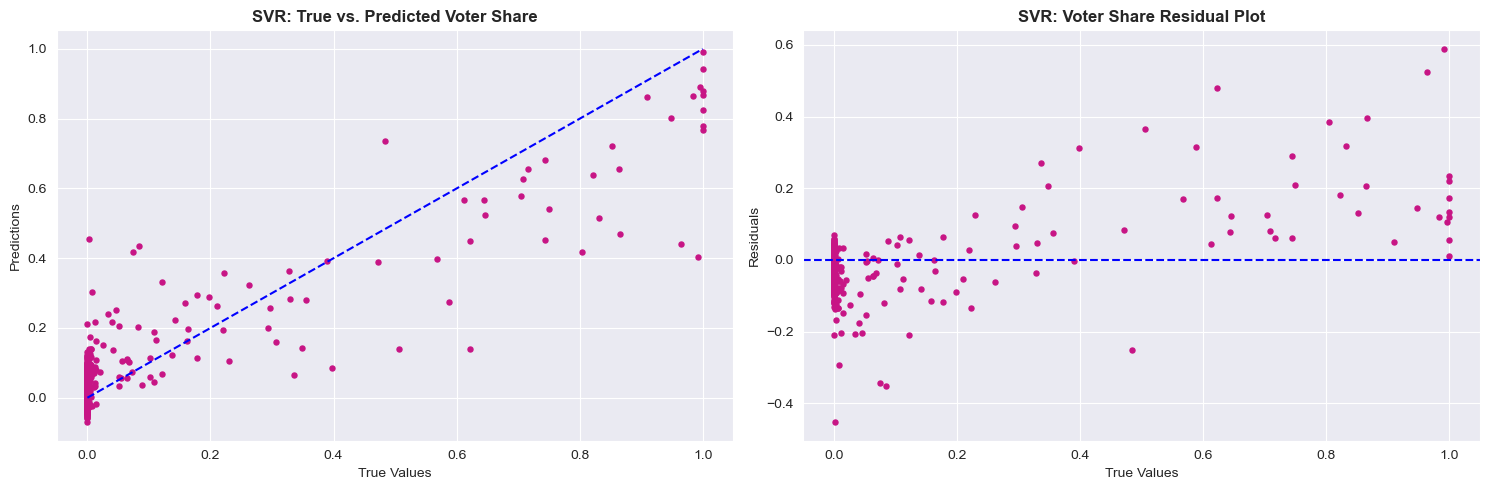

In [20]:
residplot('SVR', preds_svr)

In [21]:
print(f'---------- {b1}SVR{b0} ----------')
print(f'----- {b1}Avg Precision{b0} -----')
print(f'------ 2017: {round(find_avgprec(preds_svr, 2017),3)} ------')
print(f'------ 2018: {round(find_avgprec(preds_svr, 2018),3)} ------')
print(f'------ 2019: {round(find_avgprec(preds_svr, 2019),3)} ------')
print(f'------ 2020: {round(find_avgprec(preds_svr, 2020),3)} ------')

---------- SVR ----------
----- Avg Precision -----
------ 2017: 0.948 ------
------ 2018: 0.911 ------
------ 2019: 0.914 ------
------ 2020: 0.846 ------


In [22]:
def make_viz(preds, yr, model):
             
    # Map predictions to their associated player
    predictions = pd.DataFrame(preds, columns=['preds'], index=y_test.index)
    players = df.filter(items=['player', 'year', 'share']).loc[df.year.isin(test_yrs)]
    
    # Create combined dataset of test true and pred values
    combo = pd.concat([players, predictions['preds']], axis=1)

    # Create true and predicted Ranks
    combo.sort_values(['year', 'share'], ascending=False, inplace=True)
    combo['Rk'] = combo.groupby('year').cumcount() + 1
    combo.sort_values(['year', 'preds'], ascending=False, inplace=True)
    combo['Pred_Rk'] = combo.groupby('year').cumcount() + 1

    # Search for top 15 actual winners among predicted winners
    top15_players = combo[combo.year==yr].sort_values('Pred_Rk').head(15)            

    # Create a bar chart
    sns.set_style('darkgrid')
    fig, ax = plt.subplots(figsize=(9, 5))
    
    top15_players_sorted = top15_players.sort_values(by='Pred_Rk', ascending=False).reset_index(drop=True)

    # Set the y-axis labels to player names
    ax.set_yticks(range(len(top15_players_sorted)))
    ax.set_yticklabels(top15_players_sorted['player'])

    # Plot the true rank bars
    ax.barh(range(len(top15_players_sorted)), top15_players_sorted['Rk'], height=0.6, color='cornflowerblue', align='edge', label='True Rank')

    # Plot the predicted rank bars
    ax.barh(range(len(top15_players_sorted)), top15_players_sorted['Pred_Rk'], height=0.45, color='teal', align='center', label='Predicted Rank')

    # Set labels and title
    ax.set_xlabel('Rank')
    ax.set_title(f'{model}: True Rank vs. Predicted Rank for Top 15 Players in {yr}', fontweight='bold')
    ax.axvline(x=15, color='mediumvioletred', linestyle='--', linewidth=2)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'../images/Rank_vs_Pred_{yr}.png', dpi=192, bbox_inches='tight'); 
    return plt.show()

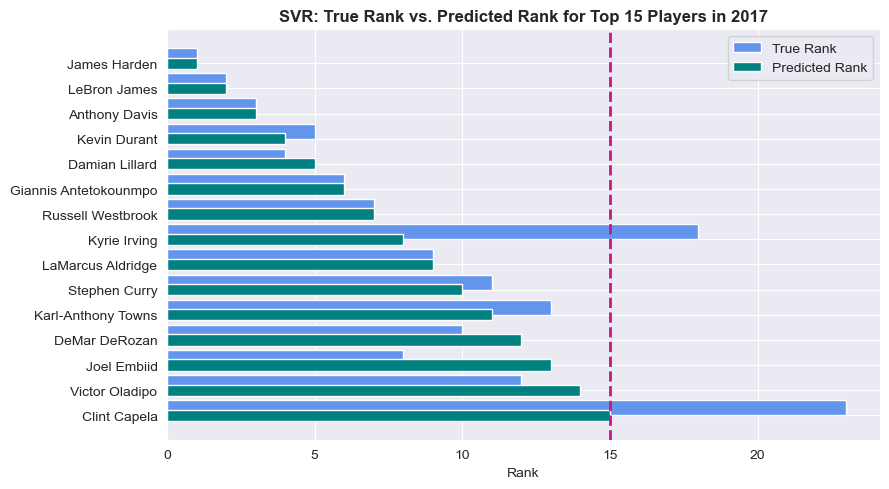

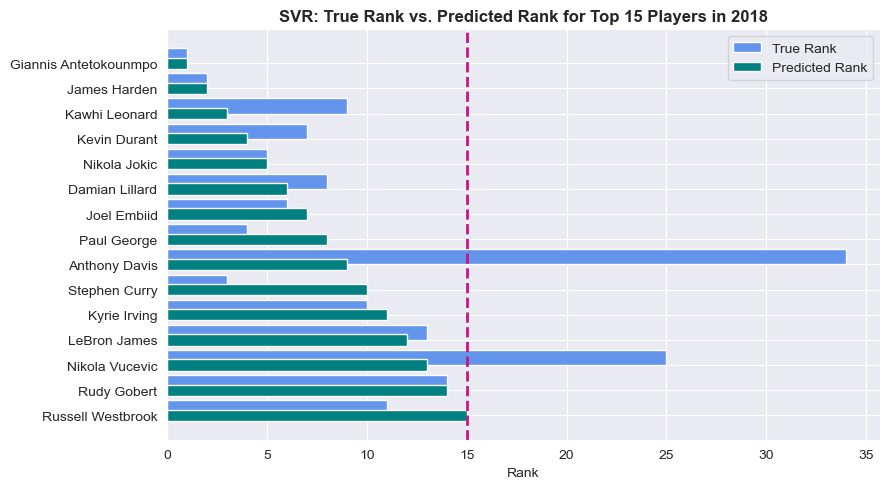

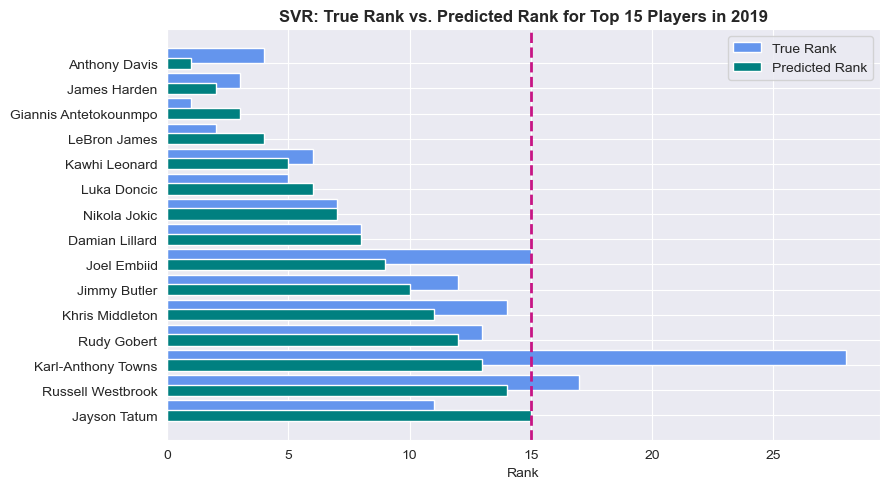

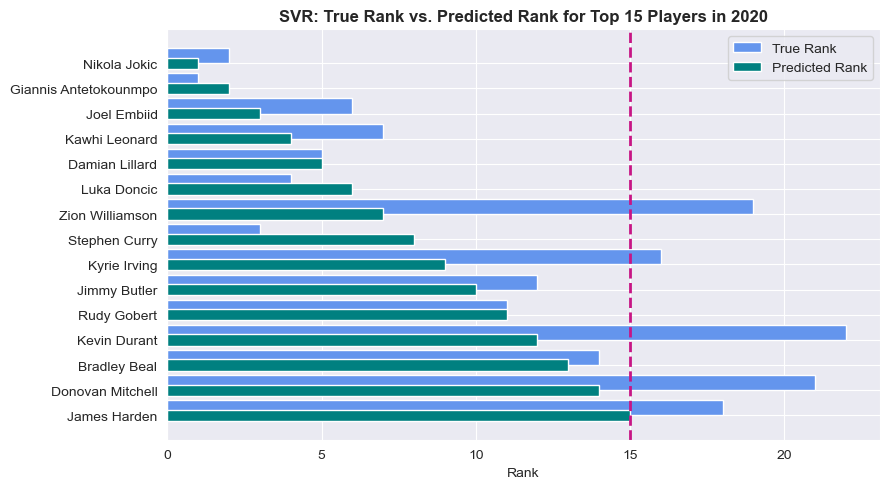

In [23]:
make_viz(preds_svr, 2017, 'SVR')
make_viz(preds_svr, 2018, 'SVR')
make_viz(preds_svr, 2019, 'SVR')
make_viz(preds_svr, 2020, 'SVR')

## II. Random Forest Regressor

In [24]:
pipe_rf = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=1527))
])

pipe_rf.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('rf', RandomForestRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'rf': RandomForestRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__criterion': 'squared_error',
 'rf__max_depth': None,
 'rf__max_features': 1.0,
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 1527,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [25]:
pgrid_rf =[
    {'rf__n_estimators': [175],
     'rf__max_depth': [50],
     'rf__max_features': [5]
    }]

In [26]:
%%time

gs_rf = GridSearchCV(pipe_rf, pgrid_rf, cv=5, n_jobs=10)
gs_rf.fit(X_train, y_train)

CPU times: total: 312 ms
Wall time: 8.61 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf',
                                        RandomForestRegressor(random_state=1527))]),
             n_jobs=10,
             param_grid=[{'rf__max_depth': [50], 'rf__max_features': [5],
                          'rf__n_estimators': [175]}])

In [27]:
preds_rf = gs_rf.predict(X_test)

In [28]:
print(f'------------- {b1}Random Forest w/ GridSearch{b0} ------------')
print(f'------------------- Train: {round(gs_rf.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_rf.score(X_test, y_test),4)} ---------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_rf, squared=False),4)} ---------------------')
print('Best Params:', gs_rf.best_params_)

------------- Random Forest w/ GridSearch ------------
------------------- Train: 0.9691 --------------------
------------------- Test: 0.8011 ---------------------
------------------- RMSE: 0.0931 ---------------------
Best Params: {'rf__max_depth': 50, 'rf__max_features': 5, 'rf__n_estimators': 175}


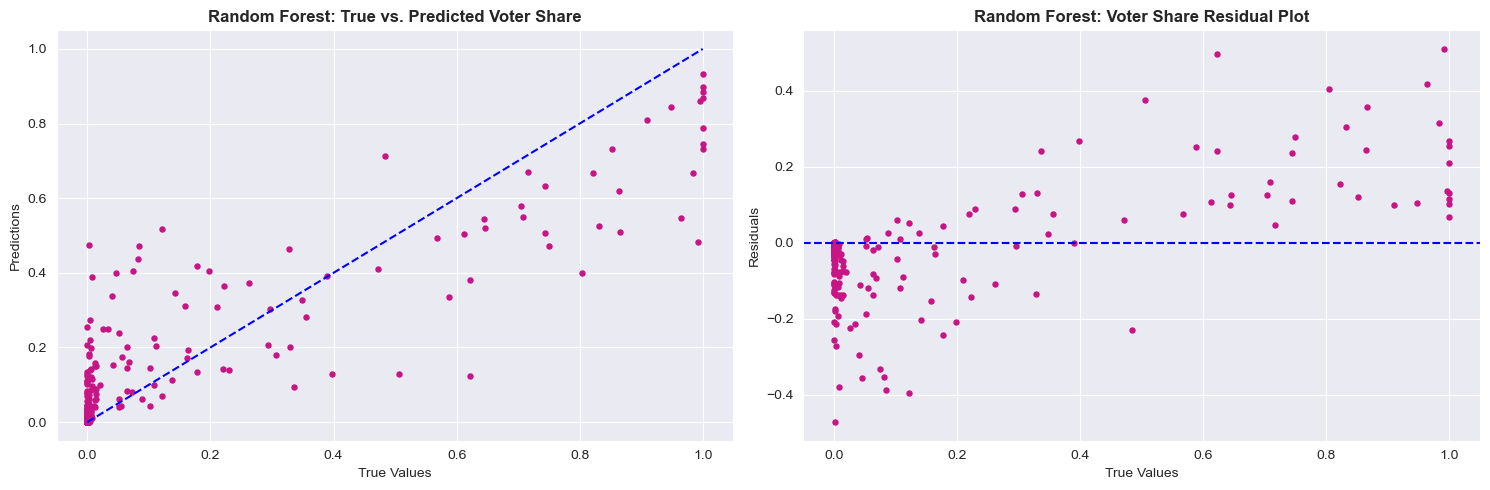

In [29]:
residplot('Random Forest', preds_rf)

In [30]:
best_estimator = gs_rf.best_estimator_
random_forest = best_estimator.named_steps['rf']
feature_importances = random_forest.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['g' 'pg_gs' 'pg_mp' 'adv_per' 'adv_ws' 'adv_vorp' 'adv_ws/48' 'adv_bpm'
 'adv_obpm' 'all_star' 'tot_pts' 'pg_pts' 'pg_2p' 'adv_ts%' 'adv_ows'
 'w/l%' 'seed' 'adv_usg%' 'f' 'gu']
[0.01034889 0.00908866 0.01518542 0.19557682 0.13016526 0.13022308
 0.05857365 0.0985898  0.05041459 0.0469335  0.0377058  0.0446769
 0.03600224 0.01848747 0.02073185 0.03665231 0.0270027  0.03035897
 0.00152867 0.00175342]


In [31]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

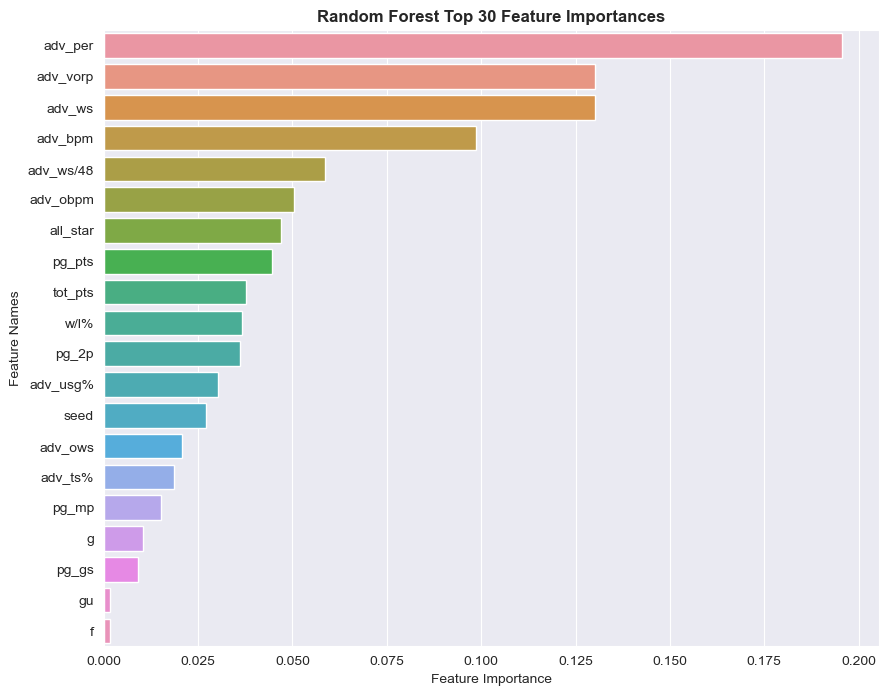

In [32]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('Random Forest Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

plt.savefig('../images/Feature_Importances_RF.png', dpi=192, bbox_inches='tight'); 

In [33]:
print(f'----- {b1}Random Forest{b0} -----')
print(f'----- {b1}Avg Precision{b0} -----')
print(f'------ 2017: {round(find_avgprec(preds_rf, 2017),3)} ------')
print(f'------ 2018: {round(find_avgprec(preds_rf, 2018),3)} ------')
print(f'------ 2019: {round(find_avgprec(preds_rf, 2019),3)} ------')
print(f'------ 2020: {round(find_avgprec(preds_rf, 2020),3)} ------')

----- Random Forest -----
----- Avg Precision -----
------ 2017: 0.946 ------
------ 2018: 0.921 ------
------ 2019: 0.881 ------
------ 2020: 0.754 ------


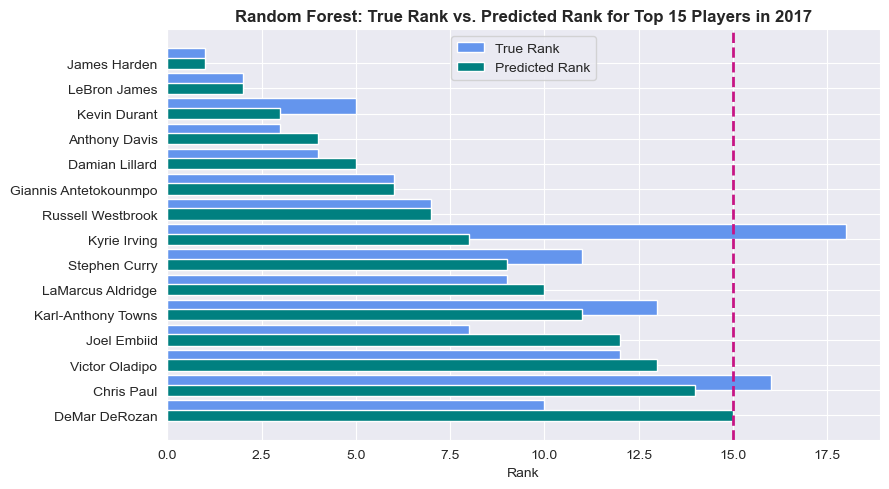

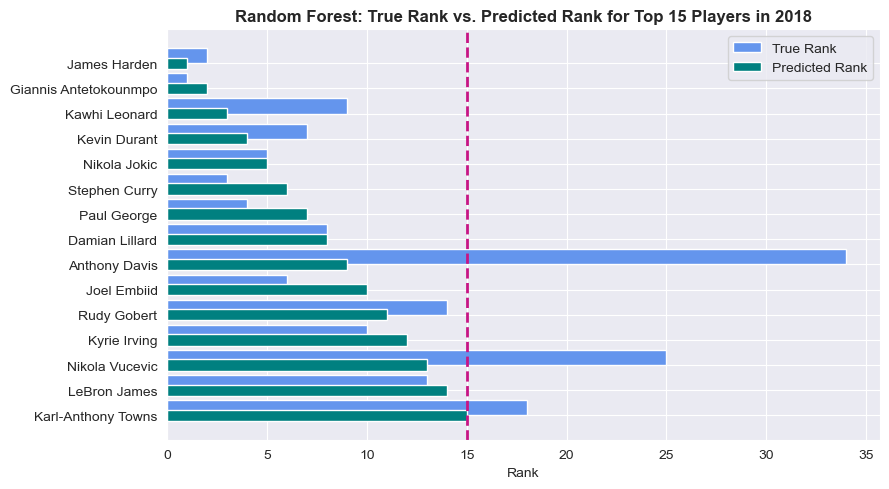

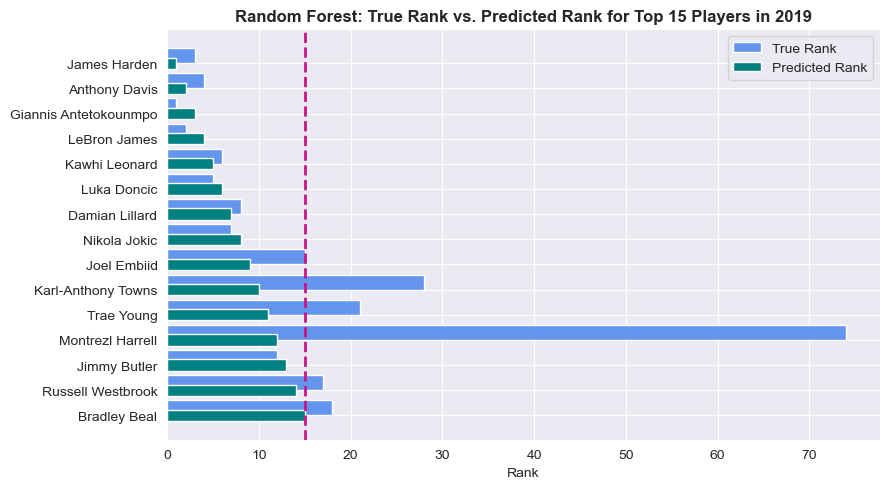

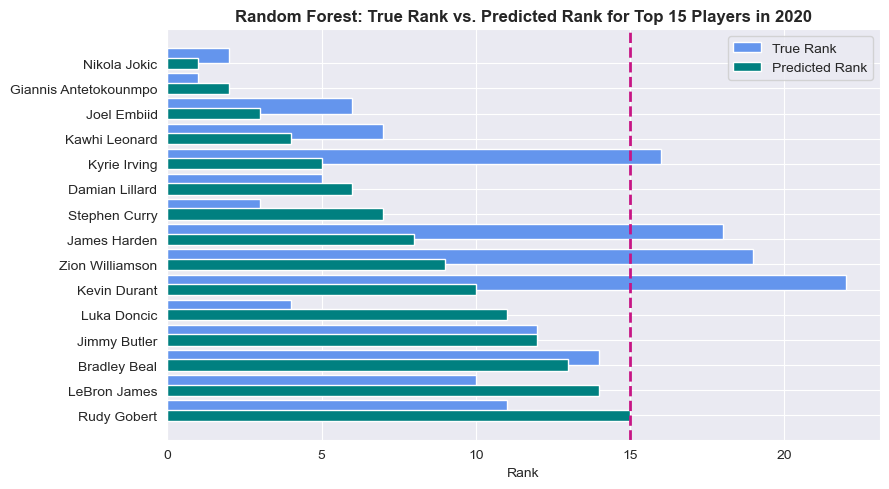

In [34]:
make_viz(preds_rf, 2017, 'Random Forest')
make_viz(preds_rf, 2018, 'Random Forest')
make_viz(preds_rf, 2019, 'Random Forest')
make_viz(preds_rf, 2020, 'Random Forest')

## III. Elastic Net

In [35]:
pipe_el = Pipeline([
    ('sc', StandardScaler()),
    ('el', ElasticNet(random_state = 1527))
])

pipe_el.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('el', ElasticNet(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'el': ElasticNet(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'el__alpha': 1.0,
 'el__copy_X': True,
 'el__fit_intercept': True,
 'el__l1_ratio': 0.5,
 'el__max_iter': 1000,
 'el__positive': False,
 'el__precompute': False,
 'el__random_state': 1527,
 'el__selection': 'cyclic',
 'el__tol': 0.0001,
 'el__warm_start': False}

In [36]:
pgrid_el =[
    {'el__alpha': [0.01], #np.linspace(0.01, 10, 10), 
     'el__l1_ratio': [0.001], #np.linspace(0.001, 1, 20),
     'el__max_iter': [300]
    }]

In [37]:
%%time

gs_el = GridSearchCV(pipe_el, pgrid_el, cv=5, n_jobs=10)
gs_el.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 110 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('el', ElasticNet(random_state=1527))]),
             n_jobs=10,
             param_grid=[{'el__alpha': [0.01], 'el__l1_ratio': [0.001],
                          'el__max_iter': [300]}])

In [38]:
preds_el = gs_el.predict(X_test)

In [39]:
print(f'-------------- {b1}Elastic Net w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_el.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_el.score(X_test, y_test),4)} ---------------------')
print(f'------------------ RMSE: {round(mean_squared_error(y_test, preds_el, squared=False),4)} ---------------------')
print('Best Params:', gs_el.best_params_)

-------------- Elastic Net w/ GridSearch -------------
------------------- Train: 0.5954 --------------------
------------------- Test: 0.6014 ---------------------
------------------ RMSE: 0.1319 ---------------------
Best Params: {'el__alpha': 0.01, 'el__l1_ratio': 0.001, 'el__max_iter': 300}


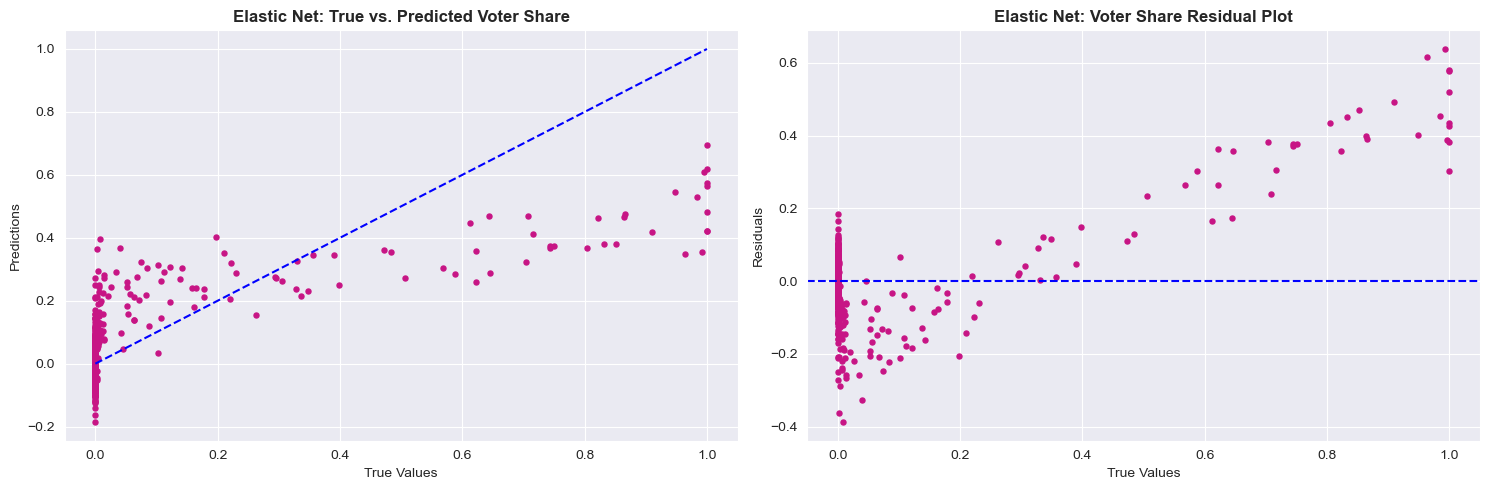

In [40]:
residplot('Elastic Net', preds_el)

In [41]:
best_el = gs_el.best_estimator_
feature_importances = best_el.named_steps['el'].coef_

In [42]:
feature_names = X_train.columns.tolist()

In [43]:
f1 = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
f1.sort_values(by=['feature_importance'], ascending=False,inplace=True)
f12 = f1.reset_index().drop(columns = ['index']).head(30)

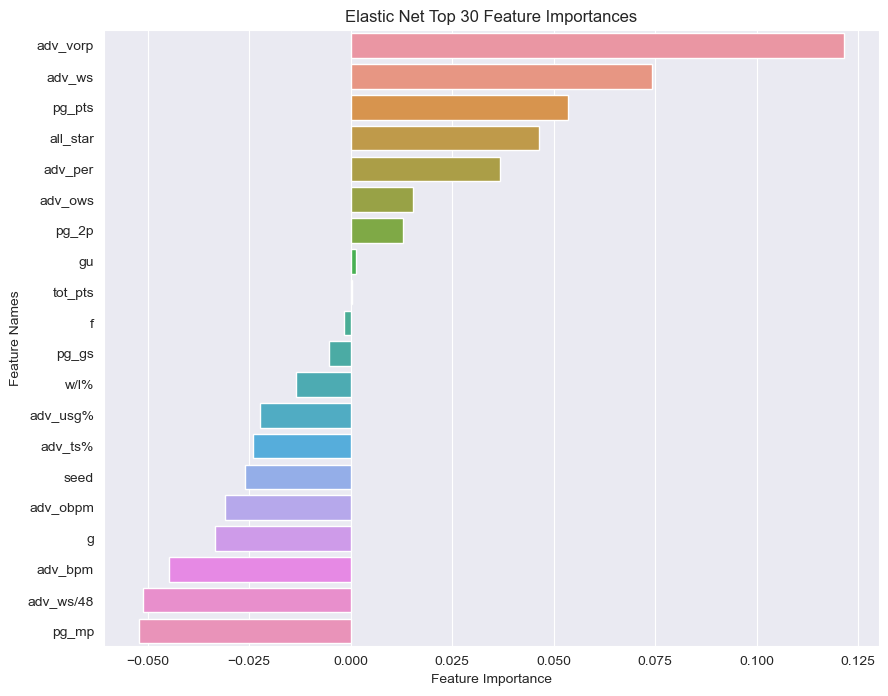

In [44]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=f12['feature_importance'], y=f12['feature_names'])
plt.title('Elastic Net Top 30 Feature Importances')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

#plt.savefig('../images/Feature_Importances_RF.png', dpi=192, bbox_inches='tight'); #Added

In [45]:
print(f'------ {b1}Elastic Net{b0} ------')
print(f'----- {b1}Avg Precision{b0} -----')
print(f'------ 2017: {round(find_avgprec(preds_el, 2017),3)} ------')
print(f'------ 2018: {round(find_avgprec(preds_el, 2018),3)} ------')
print(f'------ 2019: {round(find_avgprec(preds_el, 2019),3)} ------')
print(f'------ 2020: {round(find_avgprec(preds_el, 2020),3)} ------')

------ Elastic Net ------
----- Avg Precision -----
------ 2017: 0.924 ------
------ 2018: 0.867 ------
------ 2019: 0.9 ------
------ 2020: 0.843 ------


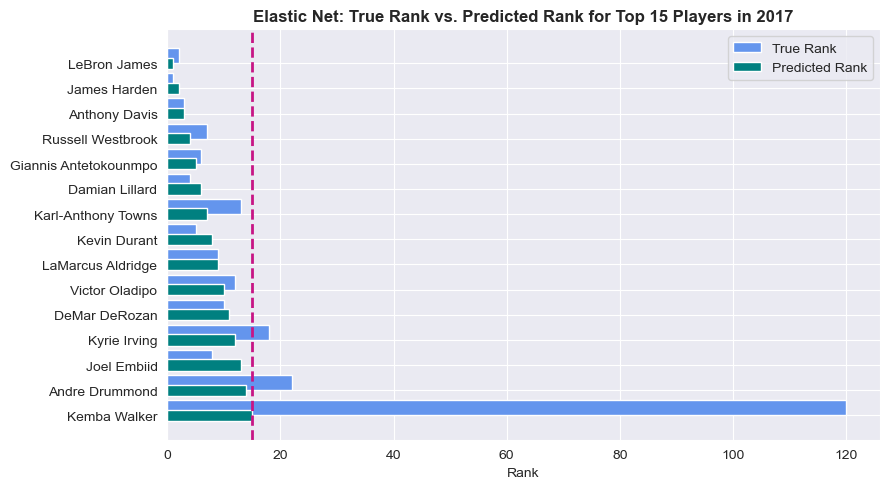

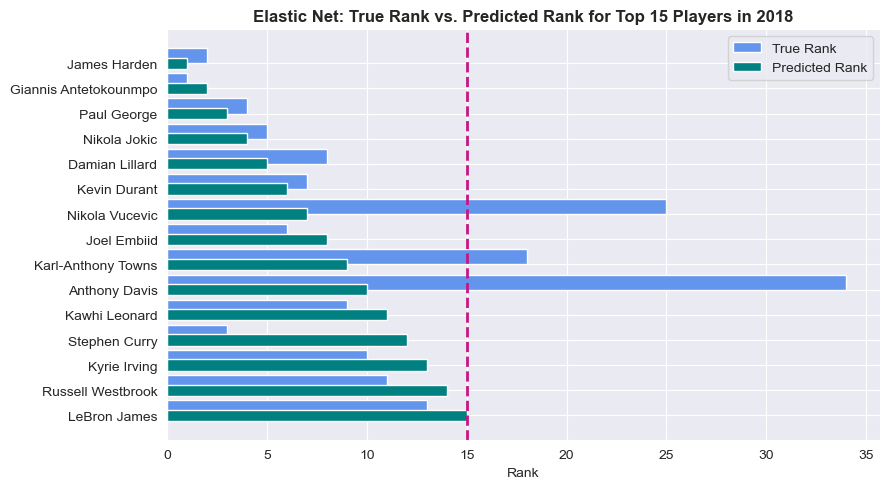

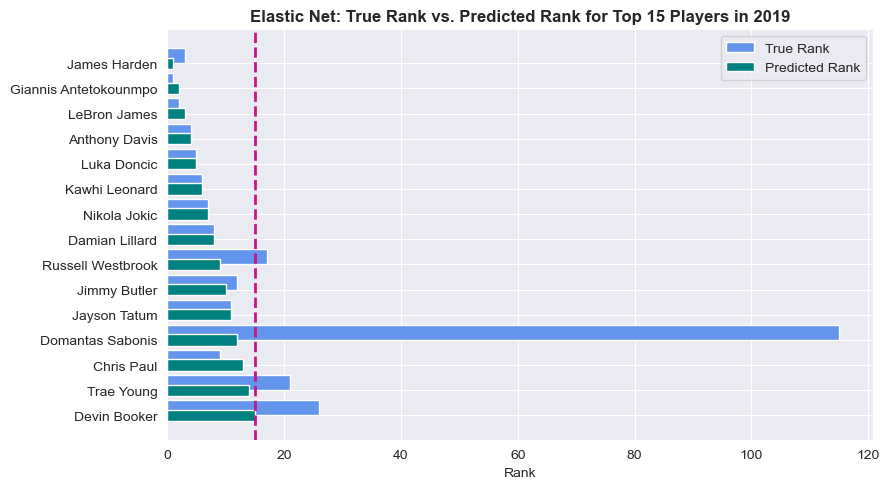

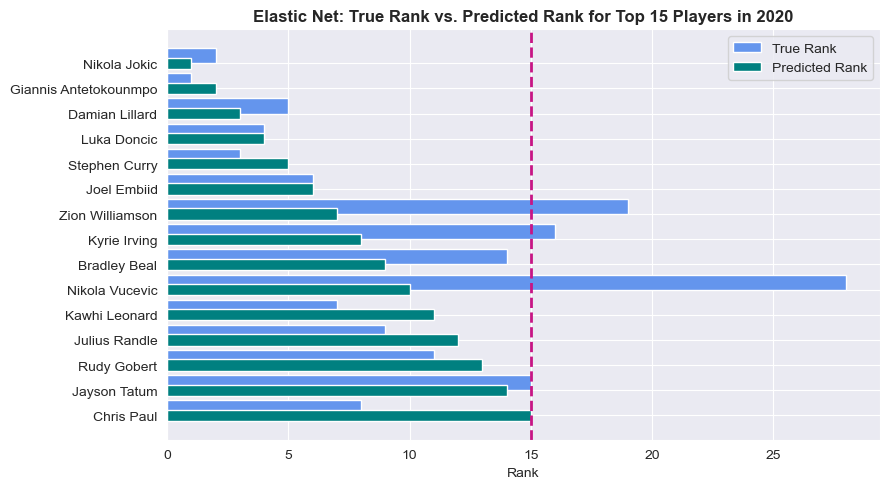

In [46]:
make_viz(preds_el, 2017, 'Elastic Net')
make_viz(preds_el, 2018, 'Elastic Net')
make_viz(preds_el, 2019, 'Elastic Net')
make_viz(preds_el, 2020, 'Elastic Net')

## IV. Extra Trees Regressor

In [47]:
pipe_et = Pipeline([
    ('sc', StandardScaler()),
    ('et', ExtraTreesRegressor(random_state=1527))
])

pipe_et.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('et', ExtraTreesRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'et': ExtraTreesRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'et__bootstrap': False,
 'et__ccp_alpha': 0.0,
 'et__criterion': 'squared_error',
 'et__max_depth': None,
 'et__max_features': 1.0,
 'et__max_leaf_nodes': None,
 'et__max_samples': None,
 'et__min_impurity_decrease': 0.0,
 'et__min_samples_leaf': 1,
 'et__min_samples_split': 2,
 'et__min_weight_fraction_leaf': 0.0,
 'et__n_estimators': 100,
 'et__n_jobs': None,
 'et__oob_score': False,
 'et__random_state': 1527,
 'et__verbose': 0,
 'et__warm_start': False}

In [48]:
pgrid_et =[
    {
    'et__n_estimators': [175], #[150, 175],
    'et__max_depth': [20], #[10, 20],
    'et__max_features': [4], #[4, 5, 6],
    'et__min_samples_leaf': [1], #[1, 3, 5],
    }
]

In [49]:
%%time

gs_et = GridSearchCV(pipe_et, pgrid_et, cv=5, scoring = 'r2', n_jobs=10)
gs_et.fit(X_train, y_train)

CPU times: total: 234 ms
Wall time: 1.74 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('et',
                                        ExtraTreesRegressor(random_state=1527))]),
             n_jobs=10,
             param_grid=[{'et__max_depth': [20], 'et__max_features': [4],
                          'et__min_samples_leaf': [1],
                          'et__n_estimators': [175]}],
             scoring='r2')

In [50]:
preds_et = gs_et.predict(X_test)

In [51]:
print(f'------------- {b1}Extra Trees w/ GridSearch{b0} -------------')
print(f'------------------- Train: {round(gs_et.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_et.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_et, squared=False),4)} --------------------')
print('Best Params:', gs_et.best_params_)

------------- Extra Trees w/ GridSearch -------------
------------------- Train: 0.9999 -------------------
------------------- Test: 0.8279 --------------------
------------------- RMSE: 0.0866 --------------------
Best Params: {'et__max_depth': 20, 'et__max_features': 4, 'et__min_samples_leaf': 1, 'et__n_estimators': 175}


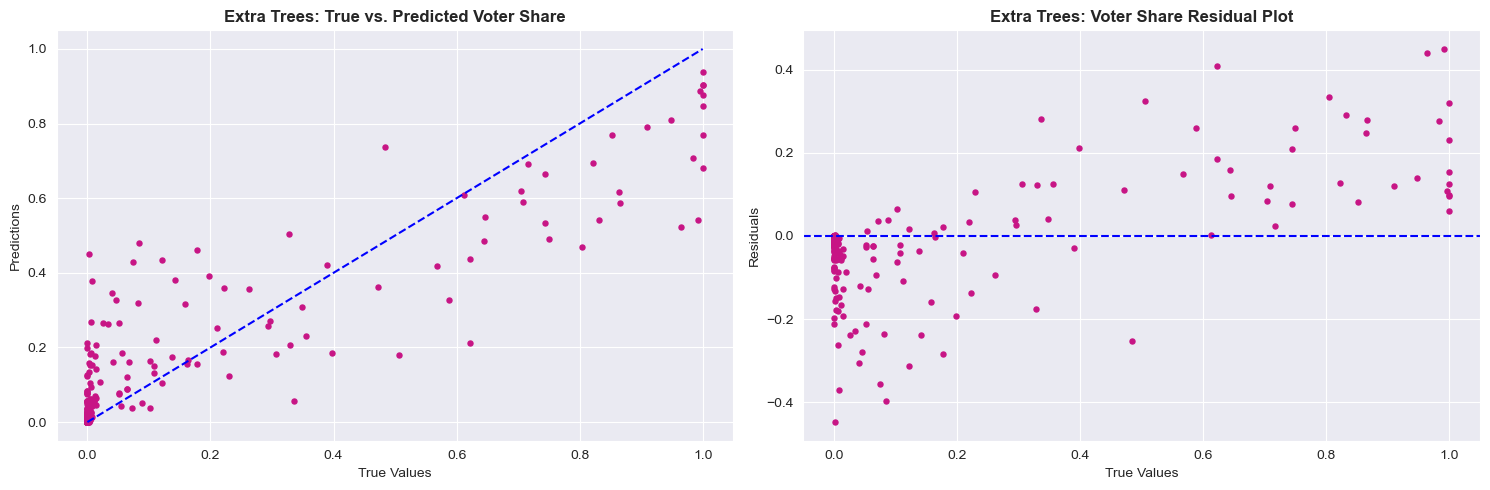

In [52]:
residplot('Extra Trees', preds_et)

In [53]:
best_estimator = gs_et.best_estimator_
extratrees = best_estimator.named_steps['et']
feature_importances = extratrees.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['g' 'pg_gs' 'pg_mp' 'adv_per' 'adv_ws' 'adv_vorp' 'adv_ws/48' 'adv_bpm'
 'adv_obpm' 'all_star' 'tot_pts' 'pg_pts' 'pg_2p' 'adv_ts%' 'adv_ows'
 'w/l%' 'seed' 'adv_usg%' 'f' 'gu']
[0.01416586 0.01411506 0.01944282 0.10342559 0.06909082 0.10087283
 0.05803696 0.07152412 0.04822025 0.15882833 0.04939588 0.06113917
 0.04958452 0.01598856 0.04668733 0.02943453 0.04128619 0.03299212
 0.00782472 0.00794435]


In [54]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

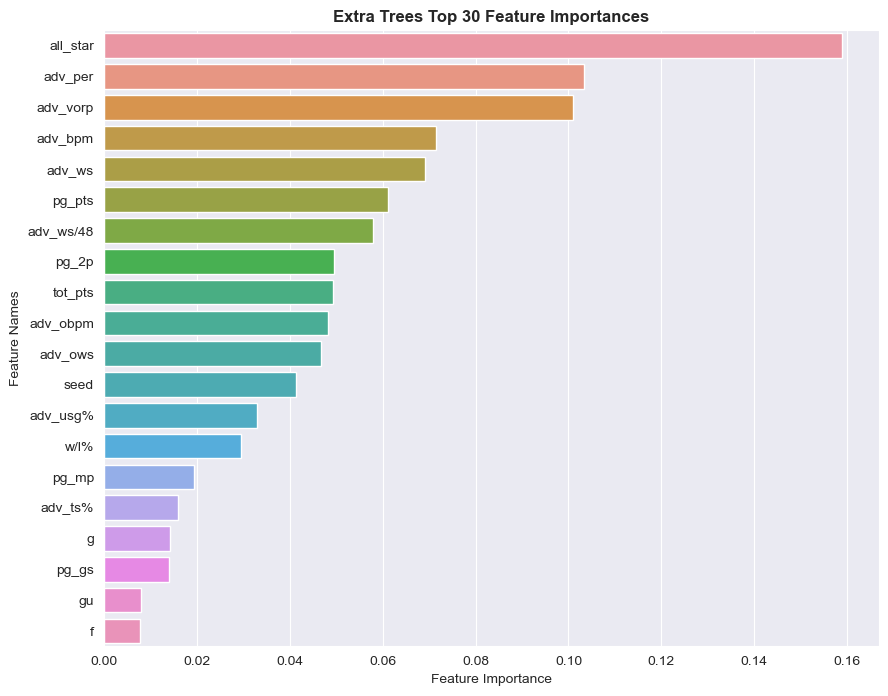

In [55]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('Extra Trees Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

plt.savefig('../images/Feature_Importances_ET.png', dpi=192, bbox_inches='tight'); 

In [56]:
print(f'------ {b1}Extra Trees{b0} ------')
print(f'----- {b1}Avg Precision{b0} -----')
print(f'------ 2017: {round(find_avgprec(preds_et, 2017),3)} ------')
print(f'------ 2018: {round(find_avgprec(preds_et, 2018),3)} ------')
print(f'------ 2019: {round(find_avgprec(preds_et, 2019),3)} ------')
print(f'------ 2020: {round(find_avgprec(preds_et, 2020),3)} ------')

------ Extra Trees ------
----- Avg Precision -----
------ 2017: 0.92 ------
------ 2018: 0.93 ------
------ 2019: 0.91 ------
------ 2020: 0.863 ------


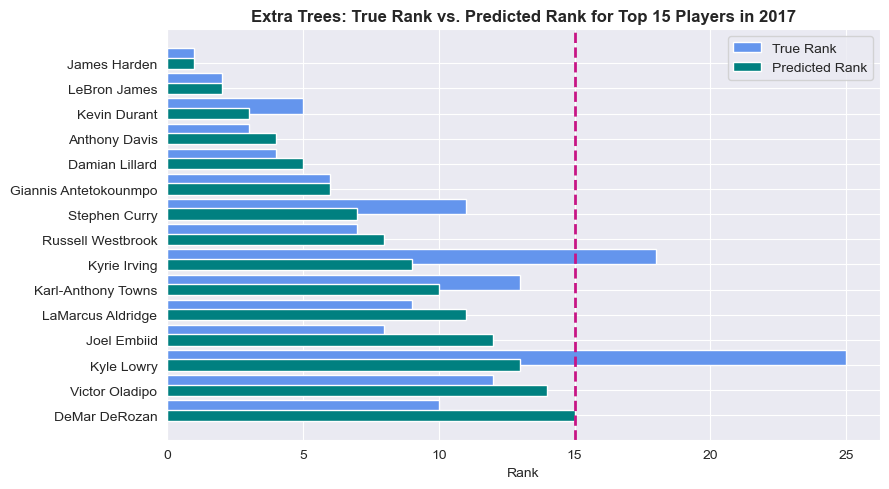

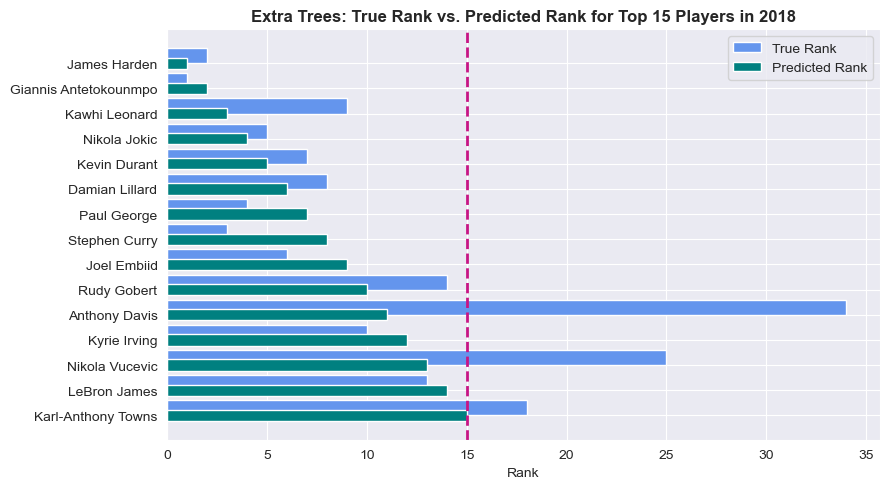

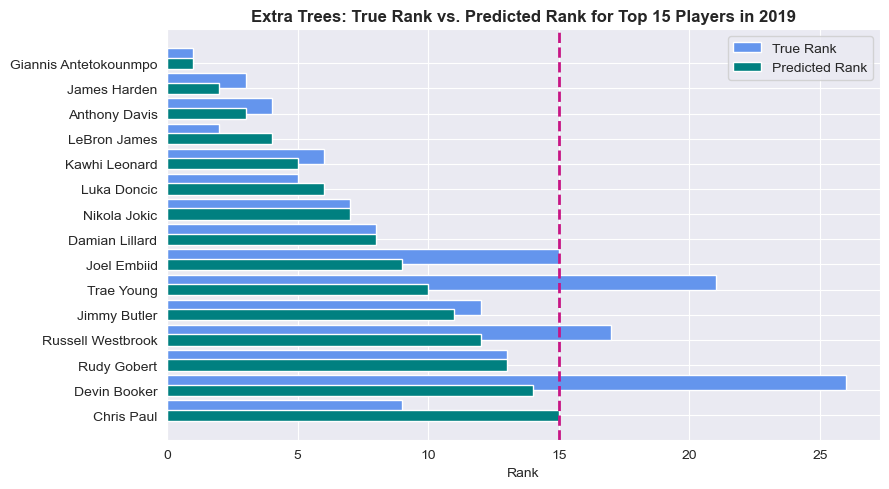

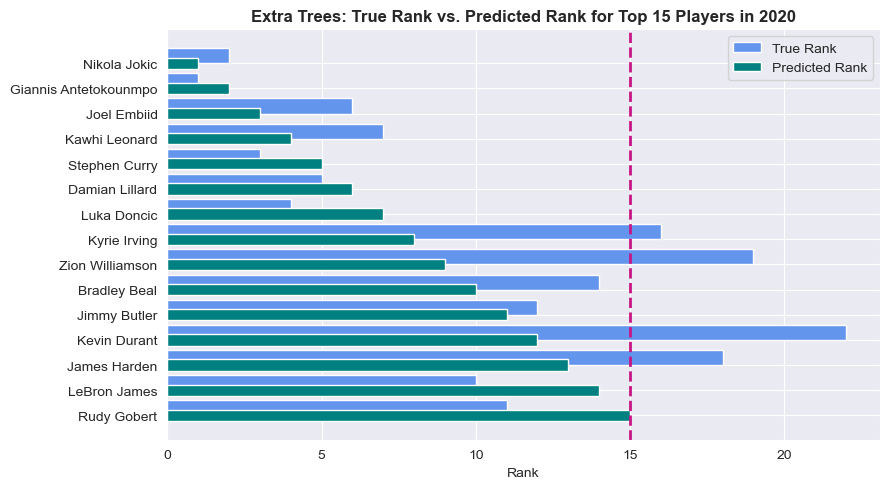

In [57]:
make_viz(preds_et, 2017, 'Extra Trees')
make_viz(preds_et, 2018, 'Extra Trees')
make_viz(preds_et, 2019, 'Extra Trees')
make_viz(preds_et, 2020, 'Extra Trees')

## V. Extreme Gradient Boosting Regressor

In [58]:
pipe_xgb = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('xgb', XGBRegressor(random_state=1527))
])

pipe_xgb.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('xgb',
   XGBRegressor(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=None, num_parallel_tree=None,
                predictor=None, random_state=1527, ...))],
 'verbose': False,
 'sc': StandardScaler(),
 'xgb': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

In [59]:
pgrid_xgb = [{
     'xgb__n_estimators': [65],
     'xgb__max_depth': [3], #[3,4,5,6],
     'xgb__learning_rate': [0.06444444444444444], # np.linspace(0.01, .5, 10),
     'xgb__reg_alpha': [0.15]    
    }]

In [60]:
%%time

gs_xgb = GridSearchCV(pipe_xgb, pgrid_xgb, cv=5, n_jobs=10)
gs_xgb.fit(X_train, y_train)

CPU times: total: 234 ms
Wall time: 270 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('xgb',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     early_stopping_rounds=None,
                                                     enable_categorical=False,
                                                     eval_metric=None,
                                                     feature_types=None,
                                                     gamma=None, gpu_id=None,
                                                     grow_policy=None,
                                                     importance_type=None,
                                                     in...
                                                     max_cat_to_onehot=None,
                                                     max_delta_step=None,
                                                     max_depth=None,
                                                     max_leaves=None,
                                                     min_child_weight=None,
                                                     missing=nan,
                                                     monotone_constraints=None,
                                                     n_estimators=100,
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     predictor=None,
                                                     random_state=1527, ...))]),
             n_jobs=10,
             param_grid=[{'xgb__learning_rate': [0.06444444444444444],
                          'xgb__max_depth': [3], 'xgb__n_estimators': [65],
                          'xgb__reg_alpha': [0.15]}])

In [61]:
preds_xgb = gs_xgb.predict(X_test)

In [62]:
print(f'----------------- {b1}XGB w/ GridSearch{b0} -----------------')
print(f'------------------- Train: {round(gs_xgb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_xgb.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_xgb, squared=False),4)} --------------------')
print('Best Params:', gs_xgb.best_params_)

----------------- XGB w/ GridSearch -----------------
------------------- Train: 0.8469 -------------------
------------------- Test: 0.7863 --------------------
------------------- RMSE: 0.0966 --------------------
Best Params: {'xgb__learning_rate': 0.06444444444444444, 'xgb__max_depth': 3, 'xgb__n_estimators': 65, 'xgb__reg_alpha': 0.15}


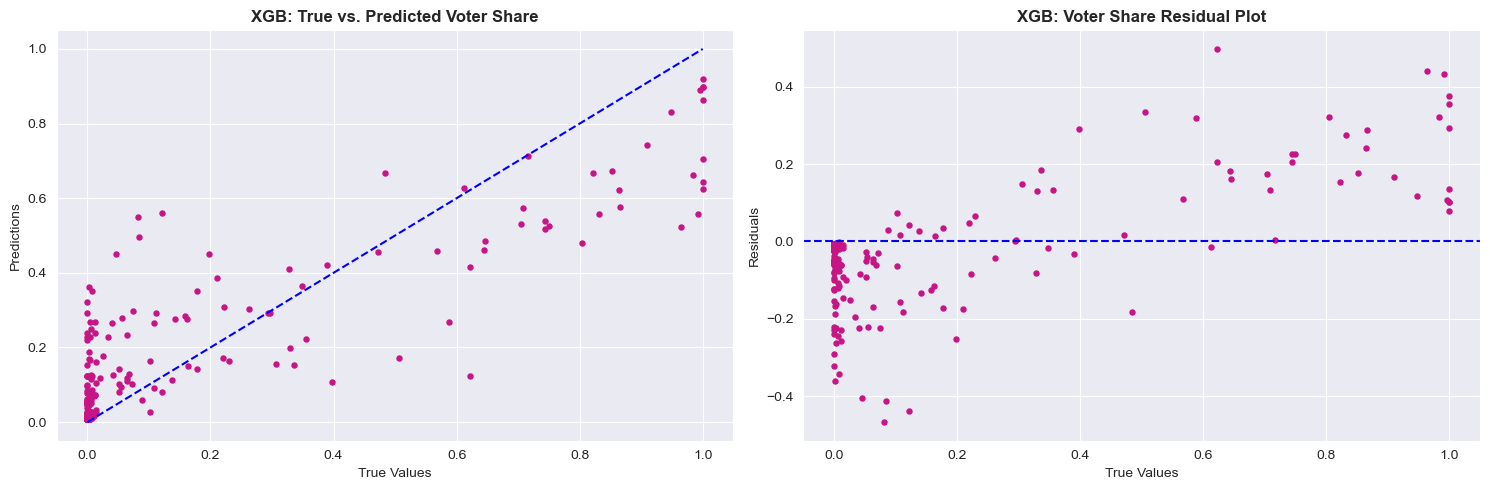

In [63]:
residplot('XGB', preds_xgb)

In [64]:
best_estimator = gs_xgb.best_estimator_
extremeboost = best_estimator.named_steps['xgb']
feature_importances = extremeboost.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['g' 'pg_gs' 'pg_mp' 'adv_per' 'adv_ws' 'adv_vorp' 'adv_ws/48' 'adv_bpm'
 'adv_obpm' 'all_star' 'tot_pts' 'pg_pts' 'pg_2p' 'adv_ts%' 'adv_ows'
 'w/l%' 'seed' 'adv_usg%' 'f' 'gu']
[0.00309808 0.01550438 0.0143504  0.50901747 0.05896417 0.0748582
 0.00877527 0.01709327 0.01209515 0.11498155 0.01966936 0.03118779
 0.01869418 0.01300335 0.00918796 0.03508174 0.03324166 0.01119605
 0.         0.        ]


In [65]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

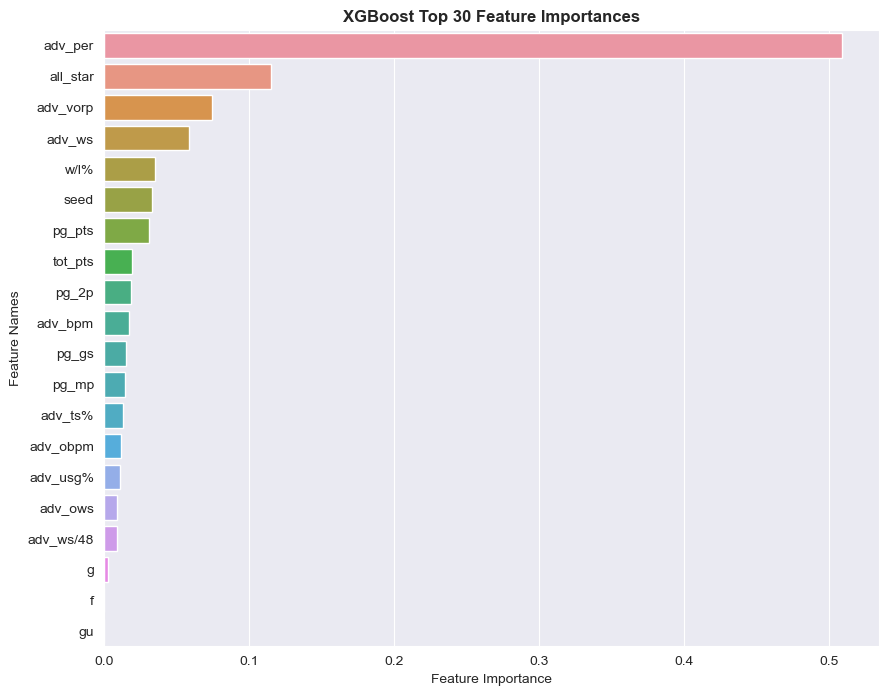

In [66]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('XGBoost Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

plt.savefig('../images/Feature_Importances_XGB.png', dpi=192, bbox_inches='tight'); 

In [67]:
print(f'---- {b1}XGB Regressor{b0} ----')
print(f'----- {b1}Avg Precision{b0} -----')
print(f'------ 2017: {round(find_avgprec(preds_xgb, 2017),3)} ------')
print(f'------ 2018: {round(find_avgprec(preds_xgb, 2018),3)} ------')
print(f'------ 2019: {round(find_avgprec(preds_xgb, 2019),3)} ------')
print(f'------ 2020: {round(find_avgprec(preds_xgb, 2020),3)} ------')

---- XGB Regressor ----
----- Avg Precision -----
------ 2017: 0.922 ------
------ 2018: 0.912 ------
------ 2019: 0.876 ------
------ 2020: 0.724 ------


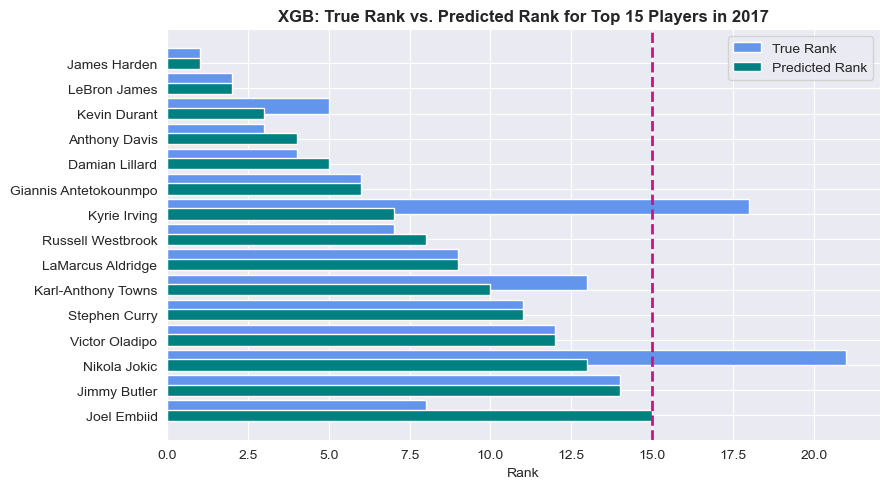

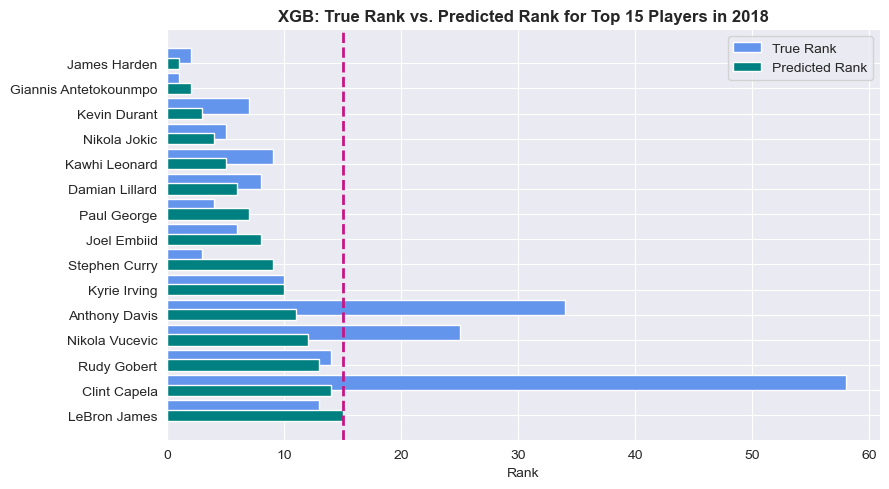

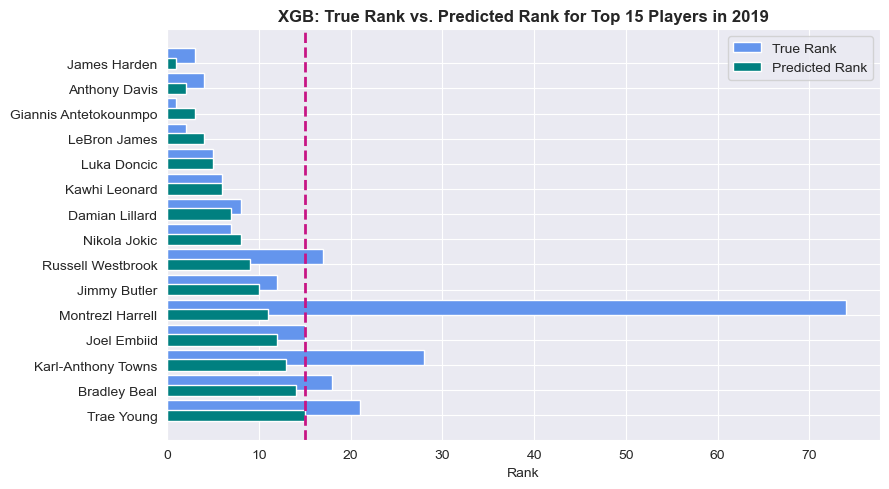

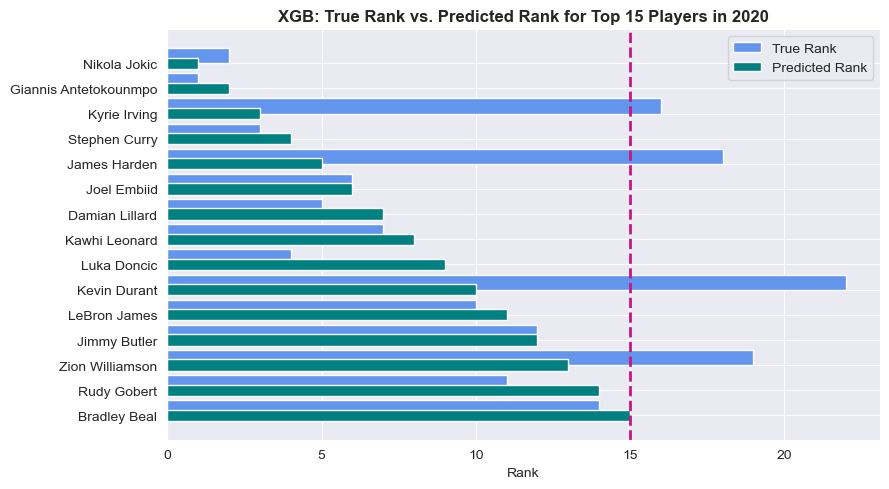

In [68]:
make_viz(preds_xgb, 2017, 'XGB')
make_viz(preds_xgb, 2018, 'XGB')
make_viz(preds_xgb, 2019, 'XGB')
make_viz(preds_xgb, 2020, 'XGB')

## VI. Gradient Boosting Regressor

In [69]:
pipe_gb = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('gb', GradientBoostingRegressor(random_state=1527))
])

pipe_gb.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('gb', GradientBoostingRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'gb': GradientBoostingRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'gb__alpha': 0.9,
 'gb__ccp_alpha': 0.0,
 'gb__criterion': 'friedman_mse',
 'gb__init': None,
 'gb__learning_rate': 0.1,
 'gb__loss': 'squared_error',
 'gb__max_depth': 3,
 'gb__max_features': None,
 'gb__max_leaf_nodes': None,
 'gb__min_impurity_decrease': 0.0,
 'gb__min_samples_leaf': 1,
 'gb__min_samples_split': 2,
 'gb__min_weight_fraction_leaf': 0.0,
 'gb__n_estimators': 100,
 'gb__n_iter_no_change': None,
 'gb__random_state': 1527,
 'gb__subsample': 1.0,
 'gb__tol': 0.0001,
 'gb__validation_fraction': 0.1,
 'gb__verbose': 0,
 'gb__warm_start': False}

In [70]:
pgrid_gb = [{
     'gb__n_estimators': [30],
     'gb__max_depth': [3],
     'gb__learning_rate': [0.11888888888888888], #np.linspace(0.01, .5, 10),
     'gb__alpha': [0.01], #np.linspace(0.01, .5, 10)
    }]

In [71]:
%%time

gs_gb = GridSearchCV(pipe_gb, pgrid_gb, cv=5, n_jobs=10)
gs_gb.fit(X_train, y_train)

CPU times: total: 0 ns
Wall time: 618 ms


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('gb',
                                        GradientBoostingRegressor(random_state=1527))]),
             n_jobs=10,
             param_grid=[{'gb__alpha': [0.01],
                          'gb__learning_rate': [0.11888888888888888],
                          'gb__max_depth': [3], 'gb__n_estimators': [30]}])

In [72]:
preds_gb = gs_gb.predict(X_test)

In [73]:
print(f'---------- {b1}Gradient Boosting w/ GridSearch{b0} ----------')
print(f'------------------- Train: {round(gs_gb.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_gb.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_gb, squared=False),4)} --------------------')
print('Best Params:', gs_gb.best_params_)

---------- Gradient Boosting w/ GridSearch ----------
------------------- Train: 0.8444 -------------------
------------------- Test: 0.7764 --------------------
------------------- RMSE: 0.0988 --------------------
Best Params: {'gb__alpha': 0.01, 'gb__learning_rate': 0.11888888888888888, 'gb__max_depth': 3, 'gb__n_estimators': 30}


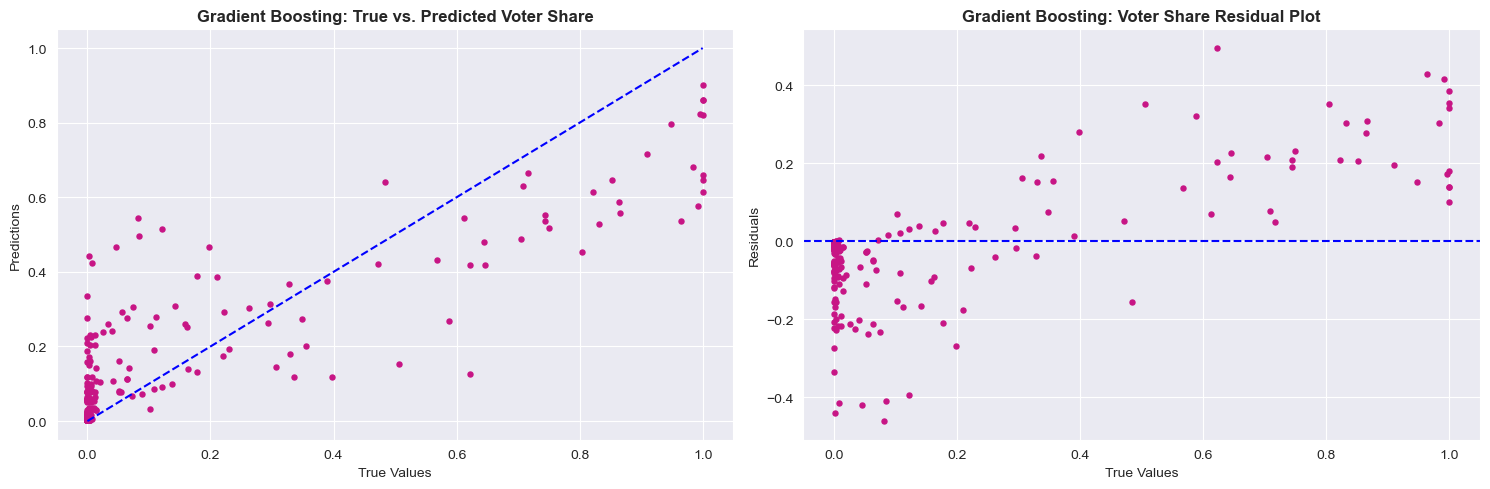

In [74]:
residplot('Gradient Boosting', preds_gb)

In [75]:
best_estimator = gs_gb.best_estimator_
gboost = best_estimator.named_steps['gb']
feature_importances = gboost.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['g' 'pg_gs' 'pg_mp' 'adv_per' 'adv_ws' 'adv_vorp' 'adv_ws/48' 'adv_bpm'
 'adv_obpm' 'all_star' 'tot_pts' 'pg_pts' 'pg_2p' 'adv_ts%' 'adv_ows'
 'w/l%' 'seed' 'adv_usg%' 'f' 'gu']
[1.09535289e-03 4.59006462e-04 1.12712992e-02 5.72056552e-01
 7.40185257e-02 8.28057678e-02 3.88901775e-03 1.09689071e-02
 7.37000732e-03 5.98255140e-02 1.31539832e-02 2.90652893e-02
 2.72577553e-02 6.42861856e-03 3.93806252e-03 6.03409391e-02
 2.54530083e-02 1.06023939e-02 0.00000000e+00 0.00000000e+00]


In [76]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

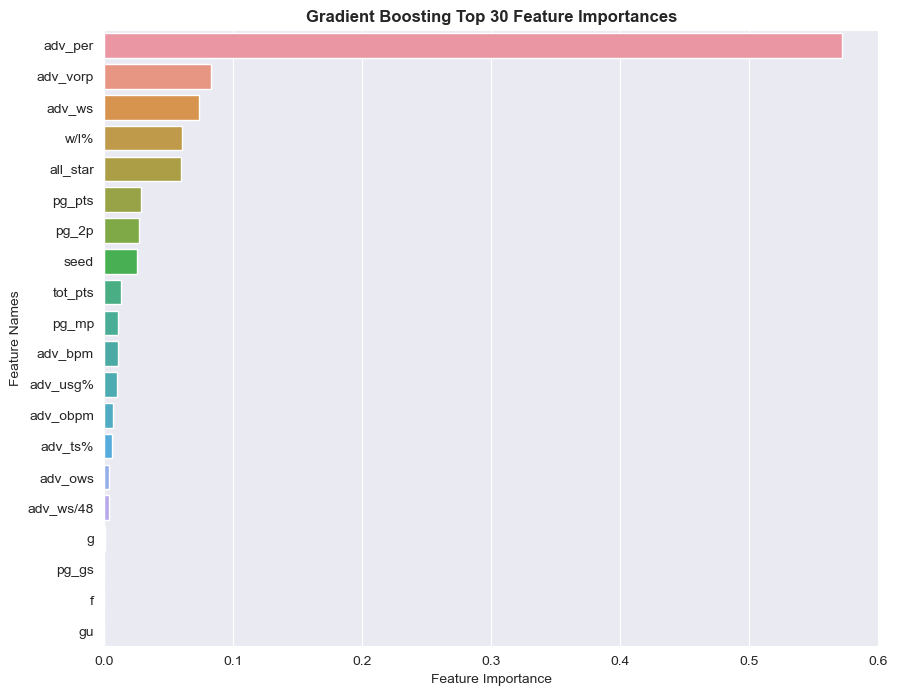

In [77]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('Gradient Boosting Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

plt.savefig('../images/Feature_Importances_GB.png', dpi=192, bbox_inches='tight'); 

In [78]:
print(f'----- {b1}GB Regressor{b0} ------')
print(f'----- {b1}Avg Precision{b0} -----')
print(f'------ 2017: {round(find_avgprec(preds_gb, 2017),3)} ------')
print(f'------ 2018: {round(find_avgprec(preds_gb, 2018),3)} ------')
print(f'------ 2019: {round(find_avgprec(preds_gb, 2019),3)} ------')
print(f'------ 2020: {round(find_avgprec(preds_gb, 2020),3)} ------')

----- GB Regressor ------
----- Avg Precision -----
------ 2017: 0.905 ------
------ 2018: 0.906 ------
------ 2019: 0.875 ------
------ 2020: 0.733 ------


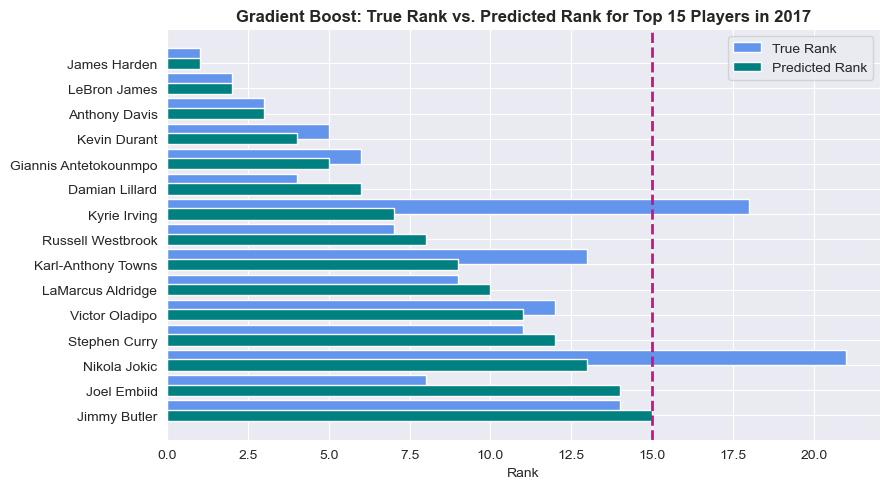

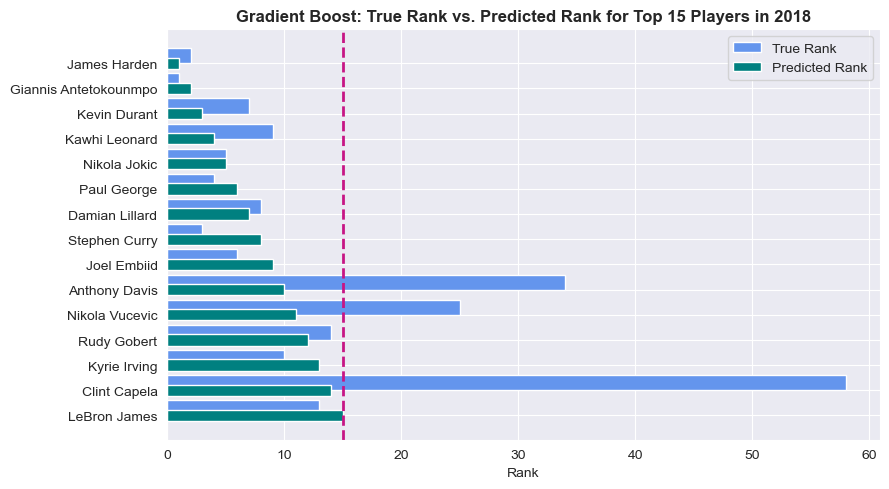

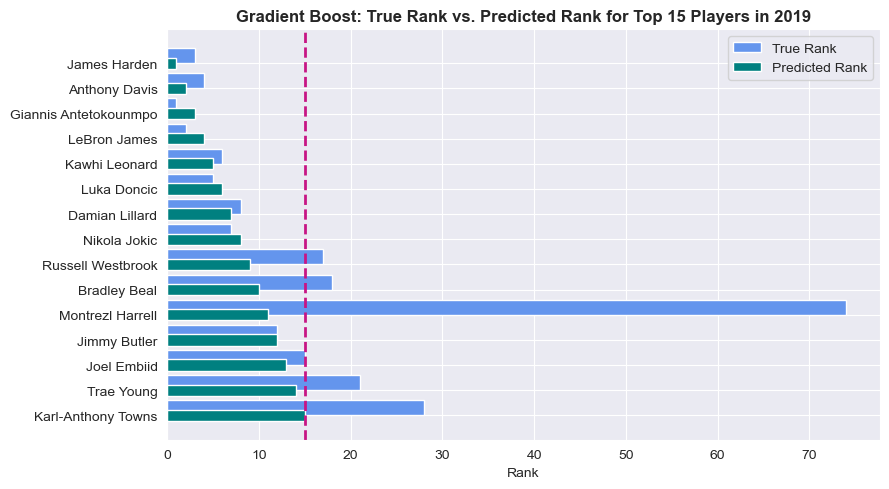

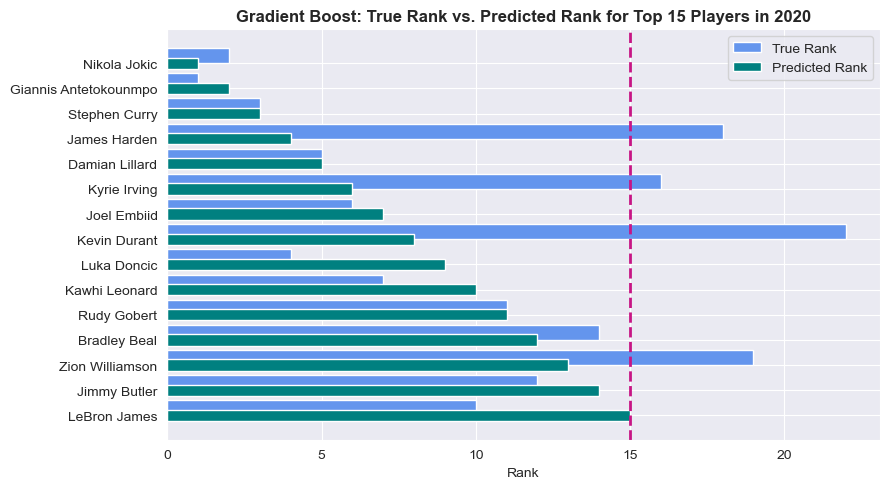

In [79]:
make_viz(preds_gb, 2017, 'Gradient Boost')
make_viz(preds_gb, 2018, 'Gradient Boost')
make_viz(preds_gb, 2019, 'Gradient Boost')
make_viz(preds_gb, 2020, 'Gradient Boost')

## VII. AdaBoost Regressor

In [80]:
pipe_ada = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('ada', AdaBoostRegressor(random_state=1527))
])

pipe_ada.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('ada', AdaBoostRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'ada': AdaBoostRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'ada__base_estimator': 'deprecated',
 'ada__estimator': None,
 'ada__learning_rate': 1.0,
 'ada__loss': 'linear',
 'ada__n_estimators': 50,
 'ada__random_state': 1527}

In [81]:
pgrid_ada = [{
     'ada__n_estimators': [70],
     'ada__learning_rate': [0.185] # np.linspace(0.01, .5, 15)
    }]

In [82]:
%%time

gs_ada = GridSearchCV(pipe_ada, pgrid_ada, cv=5, n_jobs=5)
gs_ada.fit(X_train, y_train)

CPU times: total: 219 ms
Wall time: 7.93 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('ada',
                                        AdaBoostRegressor(random_state=1527))]),
             n_jobs=5,
             param_grid=[{'ada__learning_rate': [0.185],
                          'ada__n_estimators': [70]}])

In [83]:
preds_ada = gs_ada.predict(X_test)

In [84]:
print(f'-------------- {b1}AdaBoost w/ GridSearch{b0} ---------------')
print(f'------------------- Train: {round(gs_ada.score(X_train, y_train),4)} -------------------')
print(f'------------------- Test: {round(gs_ada.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_ada, squared=False),4)} --------------------')
print('Best Params:', gs_ada.best_params_)

-------------- AdaBoost w/ GridSearch ---------------
------------------- Train: 0.7629 -------------------
------------------- Test: 0.7133 --------------------
------------------- RMSE: 0.1118 --------------------
Best Params: {'ada__learning_rate': 0.185, 'ada__n_estimators': 70}


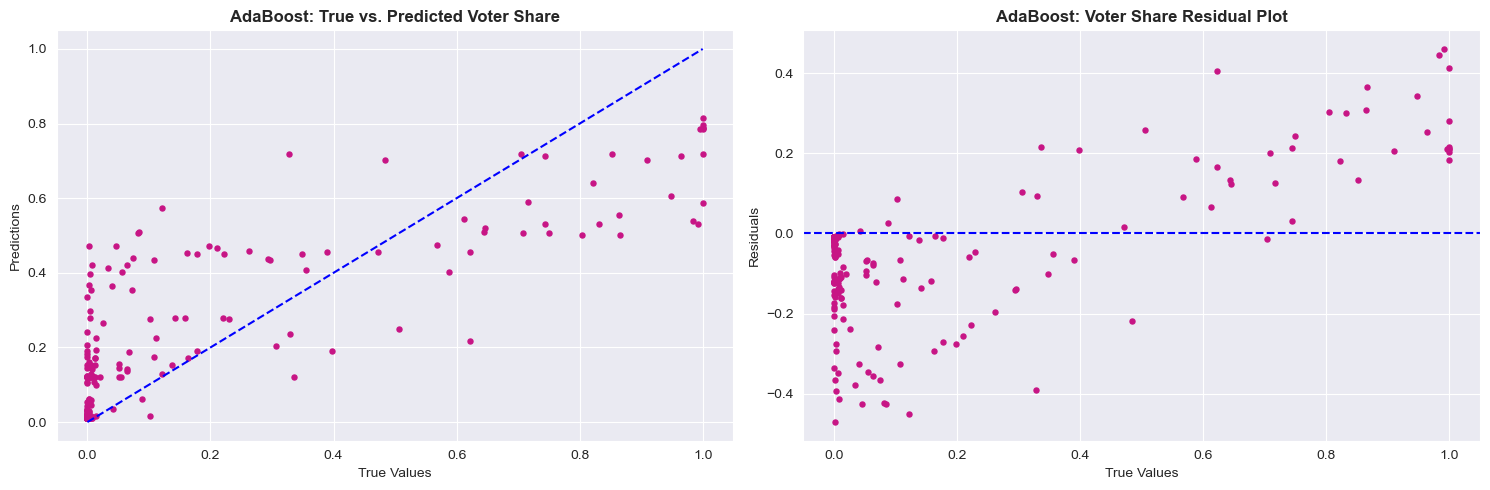

In [85]:
residplot('AdaBoost', preds_ada)

In [86]:
best_estimator = gs_ada.best_estimator_
adaboost = best_estimator.named_steps['ada']
feature_importances = adaboost.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['g' 'pg_gs' 'pg_mp' 'adv_per' 'adv_ws' 'adv_vorp' 'adv_ws/48' 'adv_bpm'
 'adv_obpm' 'all_star' 'tot_pts' 'pg_pts' 'pg_2p' 'adv_ts%' 'adv_ows'
 'w/l%' 'seed' 'adv_usg%' 'f' 'gu']
[0.00157959 0.00113881 0.03698194 0.34761162 0.01583673 0.24872048
 0.01156799 0.0394031  0.02074432 0.0470309  0.00563967 0.02979474
 0.05446245 0.01274546 0.00125745 0.06988417 0.04356686 0.01203372
 0.         0.        ]


In [87]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

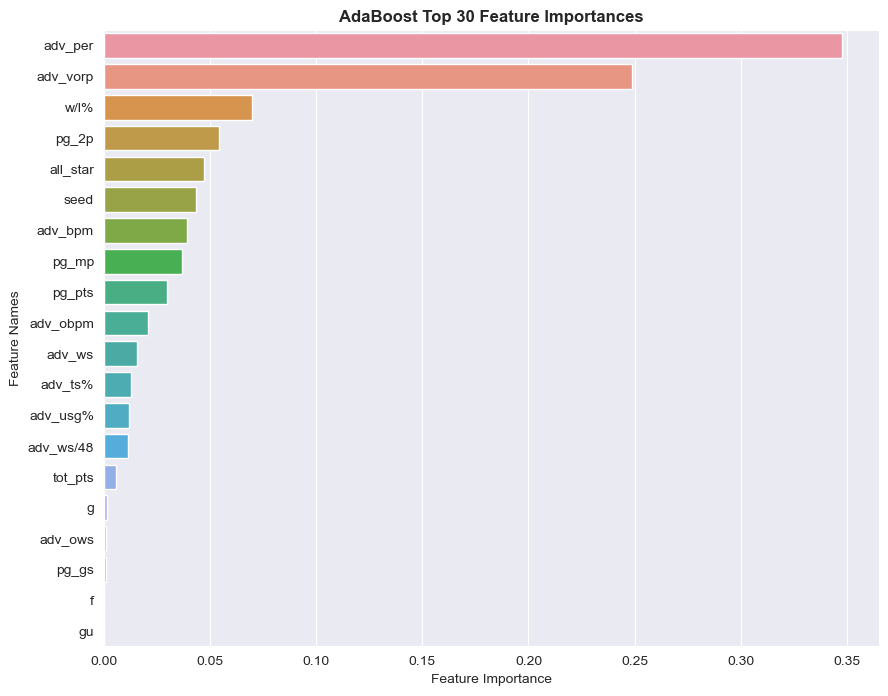

In [88]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('AdaBoost Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

plt.savefig('../images/Feature_Importances_ada.png', dpi=192, bbox_inches='tight'); 

In [89]:
print(f'------ {b1}AdaBoost Regressor{b0} -----')
print(f'-------- {b1}Avg Precision{b0} --------')
print(f'--------- 2017: {round(find_avgprec(preds_ada, 2017),3)} ---------')
print(f'--------- 2018: {round(find_avgprec(preds_ada, 2018),3)} ---------')
print(f'--------- 2019: {round(find_avgprec(preds_ada, 2019),3)} ---------')
print(f'--------- 2020: {round(find_avgprec(preds_ada, 2020),3)} ---------')

------ AdaBoost Regressor -----
-------- Avg Precision --------
--------- 2017: 0.917 ---------
--------- 2018: 0.937 ---------
--------- 2019: 0.908 ---------
--------- 2020: 0.776 ---------


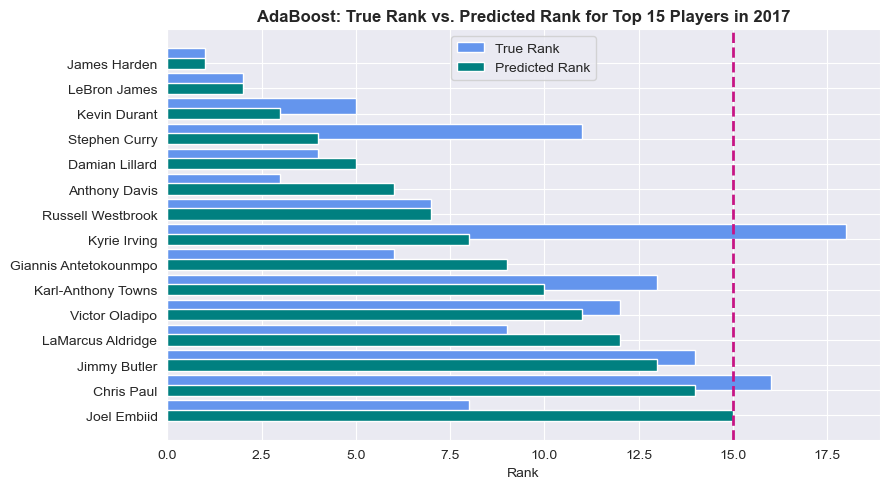

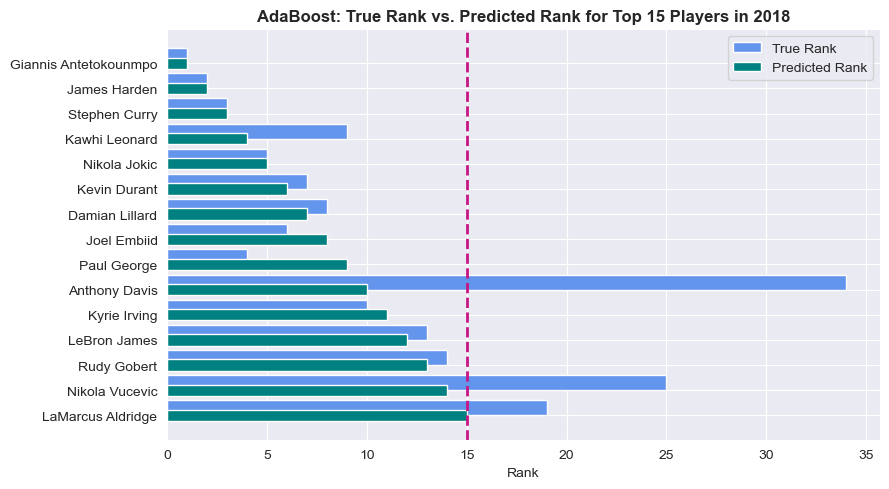

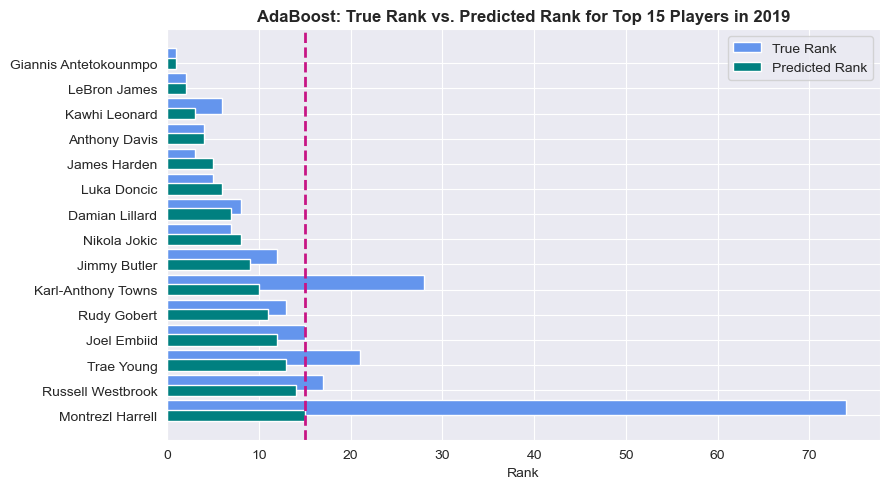

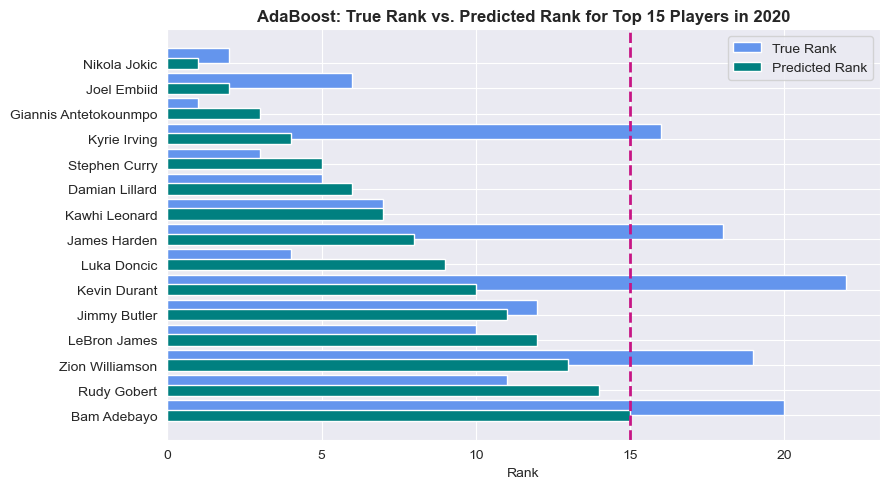

In [90]:
make_viz(preds_ada, 2017, 'AdaBoost')
make_viz(preds_ada, 2018, 'AdaBoost')
make_viz(preds_ada, 2019, 'AdaBoost')
make_viz(preds_ada, 2020, 'AdaBoost')

## VIII. Light Gradient Boosting Regressor

In [91]:
pipe_lgbm = Pipeline([
    ('sc', StandardScaler()),
    #('pc', PCA()),
    ('lgbm', LGBMRegressor(random_state=1527))
])

pipe_lgbm.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('lgbm', LGBMRegressor(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'lgbm': LGBMRegressor(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'lgbm__boosting_type': 'gbdt',
 'lgbm__class_weight': None,
 'lgbm__colsample_bytree': 1.0,
 'lgbm__importance_type': 'split',
 'lgbm__learning_rate': 0.1,
 'lgbm__max_depth': -1,
 'lgbm__min_child_samples': 20,
 'lgbm__min_child_weight': 0.001,
 'lgbm__min_split_gain': 0.0,
 'lgbm__n_estimators': 100,
 'lgbm__n_jobs': None,
 'lgbm__num_leaves': 31,
 'lgbm__objective': None,
 'lgbm__random_state': 1527,
 'lgbm__reg_alpha': 0.0,
 'lgbm__reg_lambda': 0.0,
 'lgbm__subsample': 1.0,
 'lgbm__subsample_for_bin': 200000,
 'lgbm__subsample_freq': 0}

In [92]:
pgrid_lgbm = [{
     'lgbm__learning_rate': [0.045], #np.linspace(0.01, .5, 15),
     'lgbm__max_depth': [5],
     'lgbm__n_estimators': [100],
     'lgbm__num_leaves': [12],
    }]

In [93]:
%%time

gs_lgbm = GridSearchCV(pipe_lgbm, pgrid_lgbm, cv=5, n_jobs=5)
gs_lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2348
[LightGBM] [Info] Number of data points in the train set: 3573, number of used features: 20
[LightGBM] [Info] Start training from score 0.068125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('lgbm',
                                        LGBMRegressor(random_state=1527))]),
             n_jobs=5,
             param_grid=[{'lgbm__learning_rate': [0.045],
                          'lgbm__max_depth': [5], 'lgbm__n_estimators': [100],
                          'lgbm__num_leaves': [12]}])

In [94]:
preds_lgbm = gs_lgbm.predict(X_test)

In [95]:
print(f'---------------- {b1}LGBM w/ GridSearch{b0} -----------------')
print(f'------------------- Train: {round(gs_lgbm.score(X_train, y_train),4)} --------------------')
print(f'------------------- Test: {round(gs_lgbm.score(X_test, y_test),4)} --------------------')
print(f'------------------- RMSE: {round(mean_squared_error(y_test, preds_lgbm, squared=False),4)} --------------------')
print('Best Params:', gs_lgbm.best_params_)

---------------- LGBM w/ GridSearch -----------------
------------------- Train: 0.887 --------------------
------------------- Test: 0.8131 --------------------
------------------- RMSE: 0.0903 --------------------
Best Params: {'lgbm__learning_rate': 0.045, 'lgbm__max_depth': 5, 'lgbm__n_estimators': 100, 'lgbm__num_leaves': 12}


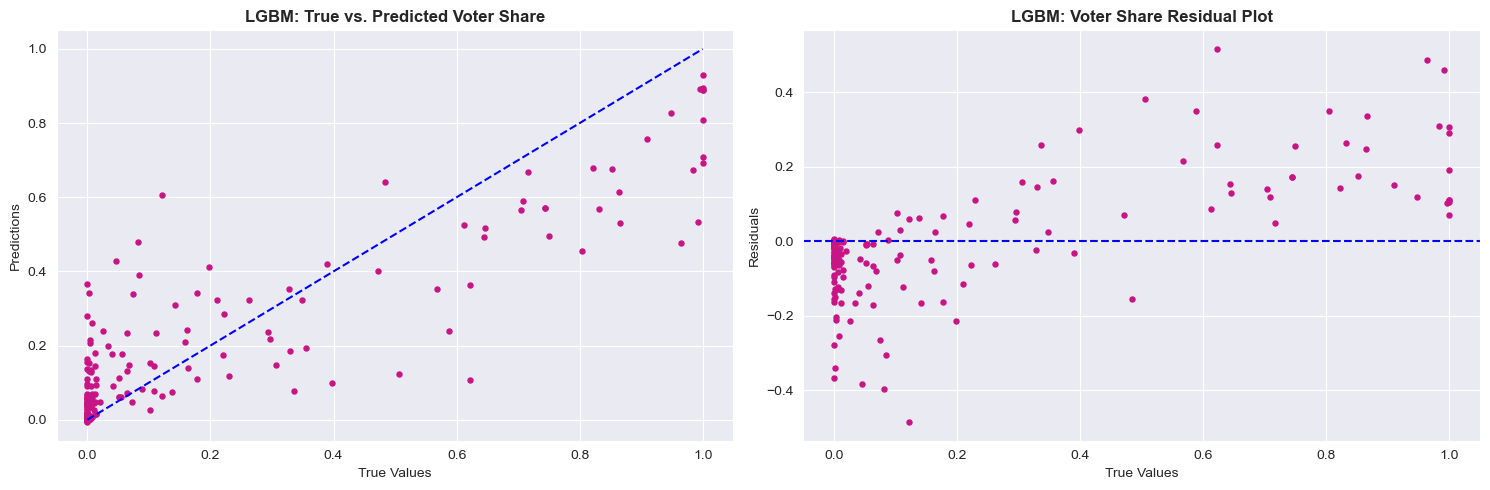

In [96]:
residplot('LGBM', preds_lgbm)

In [97]:
best_estimator = gs_lgbm.best_estimator_
lgboost = best_estimator.named_steps['lgbm']
feature_importances = lgboost.feature_importances_
best_preprocessor = best_estimator.named_steps['sc']

feature_names = best_preprocessor.get_feature_names_out()
feature_names_list = list(feature_names)

print(feature_names)
print(feature_importances)

['g' 'pg_gs' 'pg_mp' 'adv_per' 'adv_ws' 'adv_vorp' 'adv_ws/48' 'adv_bpm'
 'adv_obpm' 'all_star' 'tot_pts' 'pg_pts' 'pg_2p' 'adv_ts%' 'adv_ows'
 'w/l%' 'seed' 'adv_usg%' 'f' 'gu']
[ 20   6  88  99  69  74  33  41  54  31  41  72  89  68  32 119  56  74
   1   2]


In [98]:
fi = pd.DataFrame({'feature_names':feature_names,
                   'feature_importance': feature_importances})

#Sort by creasing feature importance
fi.sort_values(by=['feature_importance'], ascending=False,inplace=True)
fi2 = fi.reset_index().drop(columns = ['index']).head(30)

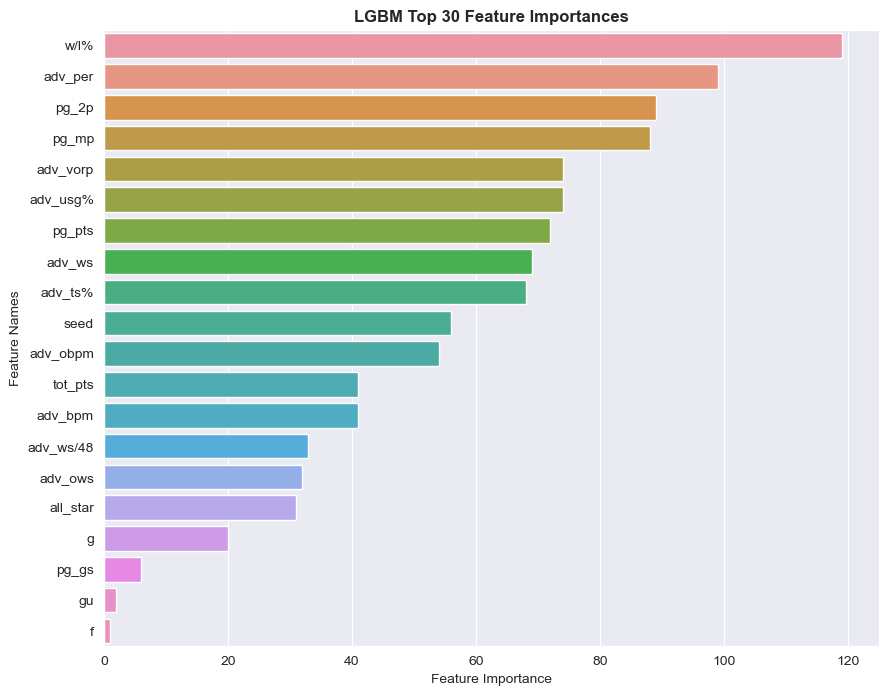

In [ ]:
#Sort the DataFrame by descending
plt.figure(figsize=(10,8))
sns.barplot(x=fi2['feature_importance'], y=fi2['feature_names'])
plt.title('LGBM Top 30 Feature Importances', fontweight='bold')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Names');

plt.savefig('../images/Feature_Importances_lgbm.png', dpi=192, bbox_inches='tight'); 

In [ ]:
print(f'---- {b1}LGBM Regressor{b0} -----')
print(f'------ {b1}Avg Precision{b0} ----')
print(f'------ 2017: {round(find_avgprec(preds_lgbm, 2017),3)} ------')
print(f'------ 2018: {round(find_avgprec(preds_lgbm, 2018),3)} ------')
print(f'------ 2019: {round(find_avgprec(preds_lgbm, 2019),3)} ------')
print(f'------ 2020: {round(find_avgprec(preds_lgbm, 2020),3)} ------')

---- LGBM Regressor -----
------ Avg Precision ----
------ 2017: 0.966 ------
------ 2018: 0.921 ------
------ 2019: 0.866 ------
------ 2020: 0.734 ------


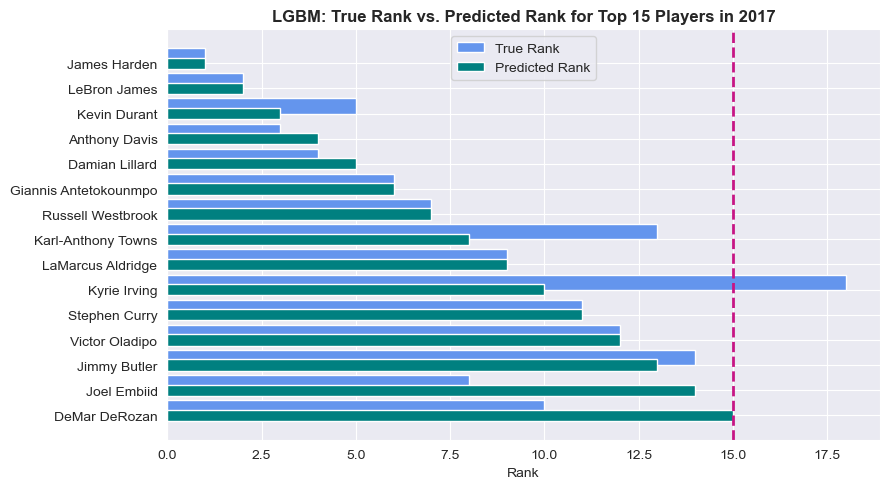

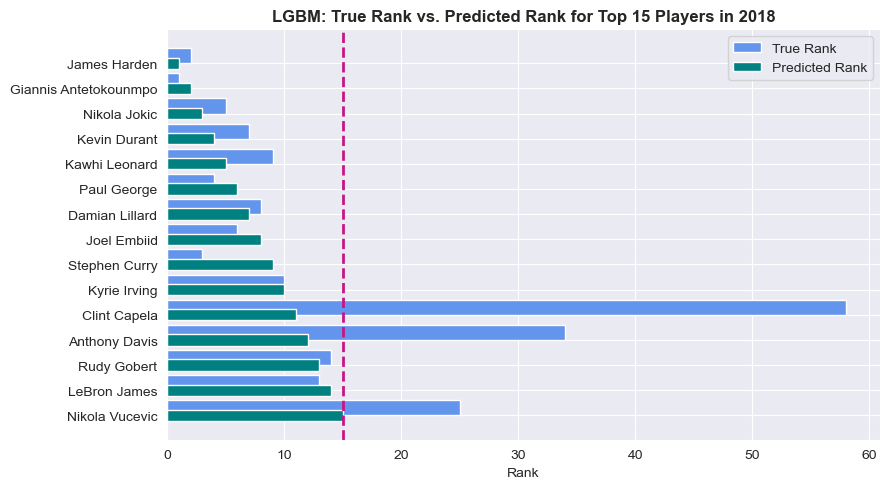

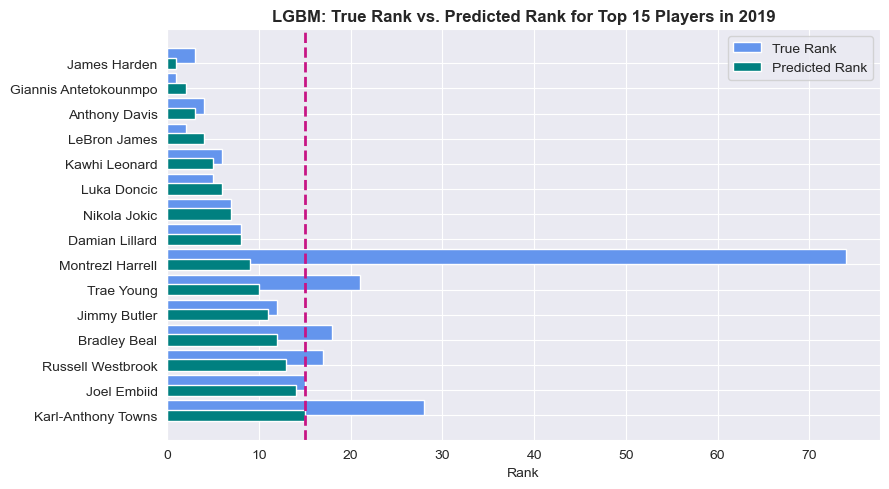

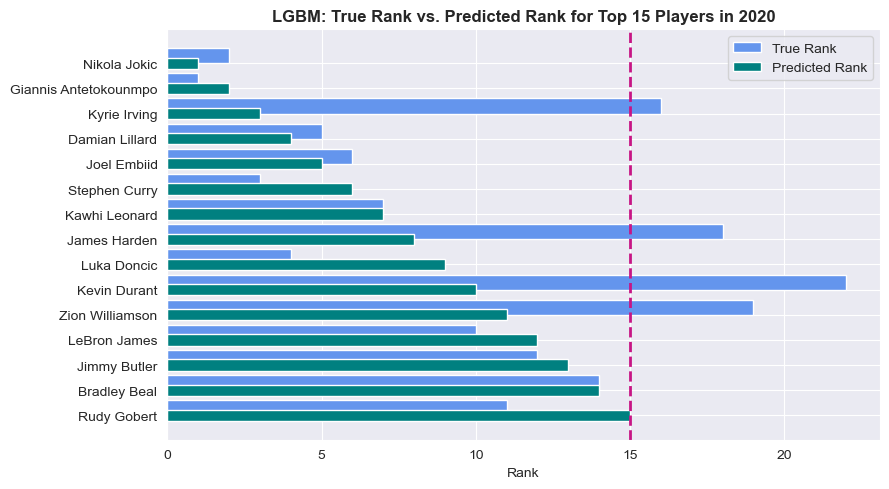

In [ ]:
make_viz(preds_lgbm, 2017, 'LGBM')
make_viz(preds_lgbm, 2018, 'LGBM')
make_viz(preds_lgbm, 2019, 'LGBM')
make_viz(preds_lgbm, 2020, 'LGBM')

## **2. Classification: Predicting 1st, 2nd, 3rd Teams**
##### In using regression to determine the Top 15 players by predicting their All-NBA Team voter share, we did not concern ourselves as much with the actual Team placement of the top players. Here, with classification, we can attempt to see which player belongs in which team, 1st, 2nd, or 3rd.

### Multiclass Classification

In [ ]:
df['all_nba_winner_c'] = df['all_nba_winner'].map({1:1, 2:2, 3:3, 4:0, 0:0})

In [ ]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(test_yrs)].reset_index(drop=True)

y_train_c = df['all_nba_winner_c'].loc[df.year.isin(train_yrs)]
y_test_c = df['all_nba_winner_c'].loc[df.year.isin(test_yrs)]

X_hold = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)
y_hold_c = df['all_nba_winner_c'].loc[df.year.isin(hold_yrs)]

print(f'Train: X: {X_train.shape}, y: {y_train_c.shape}')
print(f'Test: X: {X_test.shape}, y: {y_test_c.shape}')
print(f'Hold: X: {X_hold.shape}, y: {y_hold_c.shape}')

Train: X: (3573, 20), y: (3573,)
Test: X: (520, 20), y: (520,)
Hold: X: (279, 20), y: (279,)


### Null Model

In [ ]:
df.all_nba_winner_c.value_counts(normalize = True)

0    0.886551
2    0.037969
1    0.037740
3    0.037740
Name: all_nba_winner_c, dtype: float64

##### <span style = 'color:mediumvioletred'> _Classes are very imbalanced. We will use our models to see which placements are hardest to get right and to look for outliers or interesting cases. We will focus on sensitivity: among the true classes, how many did we predict correctly._ </span>

## IV. Logistic Regression

In [ ]:
pipe_log_c = Pipeline([
                 ('sc', StandardScaler()),
                 ('logr', LogisticRegression(solver = 'liblinear', max_iter=1000, random_state=1527))])
pipe_log_c.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('logr',
   LogisticRegression(max_iter=1000, random_state=1527, solver='liblinear'))],
 'verbose': False,
 'sc': StandardScaler(),
 'logr': LogisticRegression(max_iter=1000, random_state=1527, solver='liblinear'),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'logr__C': 1.0,
 'logr__class_weight': None,
 'logr__dual': False,
 'logr__fit_intercept': True,
 'logr__intercept_scaling': 1,
 'logr__l1_ratio': None,
 'logr__max_iter': 1000,
 'logr__multi_class': 'auto',
 'logr__n_jobs': None,
 'logr__penalty': 'l2',
 'logr__random_state': 1527,
 'logr__solver': 'liblinear',
 'logr__tol': 0.0001,
 'logr__verbose': 0,
 'logr__warm_start': False}

In [ ]:
pgrid_logr_c = [{
    'logr__C': [0.05], #np.linspace(.05,10,10),
    'logr__penalty': ['l1'], #['l1', 'l2'], #tested l1, l2 was more optimal
    'logr__max_iter': [750], #[750, 1000, 1250],
}]

In [ ]:
%%time

gs_log_c = GridSearchCV(pipe_log_c, pgrid_logr_c, cv=5, n_jobs=10)
gs_log_c.fit(X_train, y_train_c)

CPU times: total: 15.6 ms
Wall time: 5.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('logr',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=1527,
                                                           solver='liblinear'))]),
             n_jobs=10,
             param_grid=[{'logr__C': [0.05], 'logr__max_iter': [750],
                          'logr__penalty': ['l1']}])

In [ ]:
# Make predictions for Accuracy Report
preds_log_c = gs_log_c.predict(X_test)

In [ ]:
print(f'------ {b1}Multiclass Logistic Regression w/ GridSearch{b0} -------')
print(f'---------------------- Train: {round(gs_log_c.score(X_train, y_train_c),4)} ----------------------')
print(f'---------------------- Test: {round(gs_log_c.score(X_test, y_test_c),4)} -----------------------')
print('Best Params:', gs_log_c.best_params_)

------ Multiclass Logistic Regression w/ GridSearch -------
---------------------- Train: 0.9158 ----------------------
---------------------- Test: 0.9192 -----------------------
Best Params: {'logr__C': 0.05, 'logr__max_iter': 750, 'logr__penalty': 'l1'}


## X. Support Vector Classification

In [ ]:
pipe_svc_c = Pipeline([
    ('sc', StandardScaler()),
    ('svc', SVC(random_state=1527))
])
pipe_svc_c.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()), ('svc', SVC(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'svc': SVC(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': False,
 'svc__random_state': 1527,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

In [ ]:
pgrid_svc_c =[{  
     'svc__C': [0.45222222222222225], #np.linspace(0.01, 2, 10),
     'svc__degree' : [2], #[2,3,4],
     'svc__kernel': ['rbf'], #['rbf', 'linear', 'sigmoid']
    }]

In [ ]:
%%time

gs_svc_c = GridSearchCV(pipe_svc_c, pgrid_svc_c, n_jobs=5)
gs_svc_c.fit(X_train, y_train_c)

CPU times: total: 0 ns
Wall time: 4.79 s


GridSearchCV(estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('svc', SVC(random_state=1527))]),
             n_jobs=5,
             param_grid=[{'svc__C': [0.45222222222222225], 'svc__degree': [2],
                          'svc__kernel': ['rbf']}])

In [ ]:
# Make predictions for Accuracy Report
preds_svc_c = gs_svc_c.predict(X_test)

In [ ]:
print(f'----------- {b1}Multiclass SVM w/ GridSearch{b0} -----------')
print(f'------------------ Train: {round(gs_svc_c.score(X_train, y_train_c),4)} -------------------')
print(f'------------------- Test: {round(gs_svc_c.score(X_test, y_test_c),4)} -------------------')
print('Best Params:', gs_svc_c.best_params_)

----------- Multiclass SVM w/ GridSearch -----------
------------------ Train: 0.9219 -------------------
------------------- Test: 0.9288 -------------------
Best Params: {'svc__C': 0.45222222222222225, 'svc__degree': 2, 'svc__kernel': 'rbf'}


## XI. Random Forest Classification

In [ ]:
pipe_rf_c = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=1527))
])
pipe_rf_c.get_params()

{'memory': None,
 'steps': [('sc', StandardScaler()),
  ('rf', RandomForestClassifier(random_state=1527))],
 'verbose': False,
 'sc': StandardScaler(),
 'rf': RandomForestClassifier(random_state=1527),
 'sc__copy': True,
 'sc__with_mean': True,
 'sc__with_std': True,
 'rf__bootstrap': True,
 'rf__ccp_alpha': 0.0,
 'rf__class_weight': None,
 'rf__criterion': 'gini',
 'rf__max_depth': None,
 'rf__max_features': 'sqrt',
 'rf__max_leaf_nodes': None,
 'rf__max_samples': None,
 'rf__min_impurity_decrease': 0.0,
 'rf__min_samples_leaf': 1,
 'rf__min_samples_split': 2,
 'rf__min_weight_fraction_leaf': 0.0,
 'rf__n_estimators': 100,
 'rf__n_jobs': None,
 'rf__oob_score': False,
 'rf__random_state': 1527,
 'rf__verbose': 0,
 'rf__warm_start': False}

In [ ]:
pgrid_rf_c =[{
     'rf__n_estimators': [300],
     'rf__max_depth': [50],
     'rf__max_features': [30],
     'rf__min_samples_leaf': [3],
     'rf__min_samples_split': [2]
    }]

In [ ]:
%%time

gs_rf_c = GridSearchCV(pipe_rf_c, pgrid_rf_c, cv=5, n_jobs=5)
gs_rf_c.fit(X_train, y_train_c)

CPU times: total: 1.38 s
Wall time: 12.5 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sc', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(random_state=1527))]),
             n_jobs=5,
             param_grid=[{'rf__max_depth': [50], 'rf__max_features': [30],
                          'rf__min_samples_leaf': [3],
                          'rf__min_samples_split': [2],
                          'rf__n_estimators': [300]}])

In [ ]:
# Make predictions for Accuracy Report
preds_rf_c = gs_rf_c.predict(X_test)

In [ ]:
print(f'---------- {b1}Multiclass Random Forest w/ GridSearch{b0} ---------')
print(f'--------------------- Train: {round(gs_rf_c.score(X_train, y_train_c),4)} -----------------------')
print(f'--------------------- Test: {round(gs_rf_c.score(X_test, y_test_c),4)} ------------------------')
print('Best Params:', gs_rf_c.best_params_)

---------- Multiclass Random Forest w/ GridSearch ---------
--------------------- Train: 0.9863 -----------------------
--------------------- Test: 0.9288 ------------------------
Best Params: {'rf__max_depth': 50, 'rf__max_features': 30, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}


### Confusion Matrix and Accuracy Report

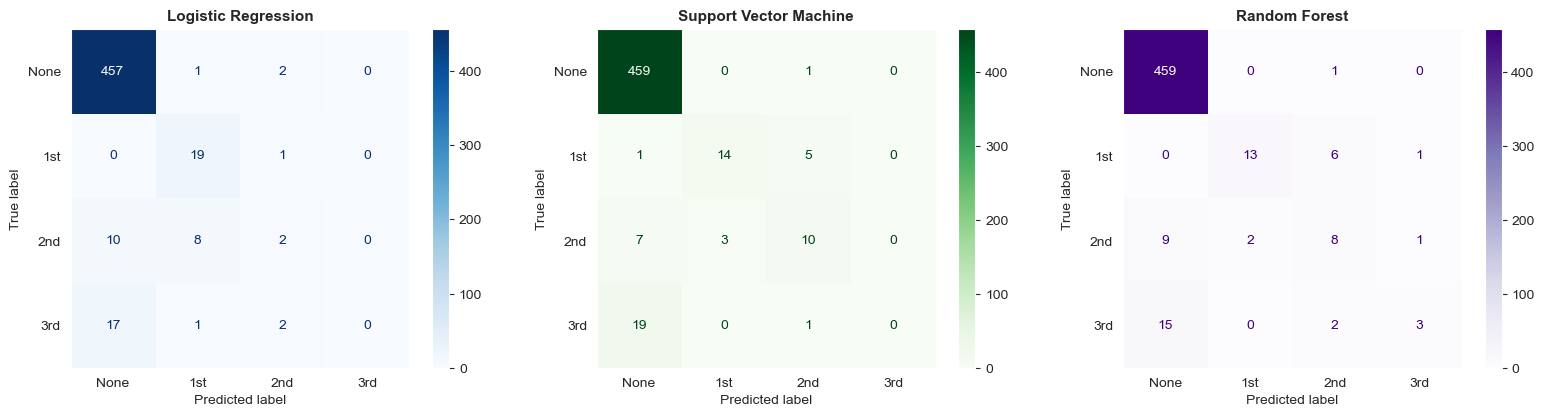

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ConfusionMatrixDisplay.from_predictions(y_test_c, preds_log_c, display_labels=['None', '1st', '2nd', '3rd'], cmap = 'Blues', ax=ax[0]);
ConfusionMatrixDisplay.from_predictions(y_test_c, preds_svc_c, display_labels=['None', '1st', '2nd', '3rd'], cmap = 'Greens', ax=ax[1]);
ConfusionMatrixDisplay.from_predictions(y_test_c, preds_rf_c, display_labels=['None', '1st', '2nd', '3rd'], cmap = 'Purples', ax=ax[2]);

plt.tight_layout()
ax[0].set_title('Logistic Regression', fontweight='bold', fontsize=11)
ax[1].set_title('Support Vector Machine', fontweight='bold', fontsize=11);
ax[2].set_title('Random Forest', fontweight='bold', fontsize=11);

ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False);

In [ ]:
print(f'\n---------------- {b1}Multiclass Logistic{b0} ----------------- \n {classification_report(y_test_c, preds_log_c, digits=4)} \n')
print(f'------------------- {b1}Multiclass SVC{b0} -------------------- \n  {classification_report(y_test_c, preds_svc_c, digits=4)}')
print(f'-------------------- {b1}Multiclass RF{b0} -------------------- \n  {classification_report(y_test_c, preds_rf_c, digits=4)} \n')


---------------- Multiclass Logistic ----------------- 
               precision    recall  f1-score   support

           0     0.9442    0.9935    0.9682       460
           1     0.6552    0.9500    0.7755        20
           2     0.2857    0.1000    0.1481        20
           3     0.0000    0.0000    0.0000        20

    accuracy                         0.9192       520
   macro avg     0.4713    0.5109    0.4730       520
weighted avg     0.8715    0.9192    0.8920       520
 

------------------- Multiclass SVC -------------------- 
                precision    recall  f1-score   support

           0     0.9444    0.9978    0.9704       460
           1     0.8235    0.7000    0.7568        20
           2     0.5882    0.5000    0.5405        20
           3     0.0000    0.0000    0.0000        20

    accuracy                         0.9288       520
   macro avg     0.5891    0.5495    0.5669       520
weighted avg     0.8898    0.9288    0.9083       520

-----------

##### <span style = 'color:mediumvioletred'> _Our models had > 99% recall in determining who did not make an All-NBA Team. Each model struggled to place the players into 1st, 2nd, and 3rd Team._ </span>

- <span style = 'color:mediumvioletred'> _Logistic Regression did the best at 1st class placements, with a sensitivity of 95%, only misclassifying one player to 2nd Team._ </span>
- <span style = 'color:mediumvioletred'> _SVC performed best at predicting 2nd Team placements, with 50% recall. Three of the 10 misclassifications placed these players in 1st Team instead of 2nd, which is close._ </span>
- <span style = 'color:mediumvioletred'> _Random Forest was the closest in terms of almost getting 3rd Team correct. The model misclassified this category 100% of the time, but for 4 of those 20 instances, this model misclassified as 2nd Team instead of 3rd, which, which is close._ </span>

### Binary Classification
##### Briefly rerunning our models to look at the difference when using Binary Classification

In [ ]:
df['binary_all_nba_winner'] = df['all_nba_winner'].map({0:0, 1:1, 2:1, 3:1, 4:0})

In [ ]:
df.binary_all_nba_winner.value_counts(normalize = True)

0    0.886551
1    0.113449
Name: binary_all_nba_winner, dtype: float64

##### <span style = 'color:mediumvioletred'> _We need our models accuracy to be > 88.4%._ </span>

In [ ]:
X_train = df[feats].loc[df.year.isin(train_yrs)].reset_index(drop=True)
X_test = df[feats].loc[df.year.isin(test_yrs)].reset_index(drop=True)

y_train_b = df['binary_all_nba_winner'].loc[df.year.isin(train_yrs)]
y_test_b = df['binary_all_nba_winner'].loc[df.year.isin(test_yrs)]

X_hold = df[feats].loc[df.year.isin(hold_yrs)].reset_index(drop=True)
y_hold_b = df['binary_all_nba_winner'].loc[df.year.isin(hold_yrs)]

print(f'Train: X: {X_train.shape}, y: {y_train_b.shape}')
print(f'Test: X: {X_test.shape}, y: {y_test_b.shape}')
print(f'Hold: X: {X_hold.shape}, y: {y_hold_b.shape}')

Train: X: (3573, 20), y: (3573,)
Test: X: (520, 20), y: (520,)
Hold: X: (279, 20), y: (279,)


In [ ]:
# Logistic

In [ ]:
pipe_log_b = Pipeline([
                 ('sc', StandardScaler()),
                 ('logr', LogisticRegression(solver = 'liblinear', max_iter=1000, random_state=1527))])

pgrid_logr_b = [{
    'logr__C': [0.05], #np.linspace(.05,10,10),
    'logr__penalty': ['l1'], #['l1', 'l2'], 
    'logr__max_iter': [750], #[750, 1000, 1250]
}]

gs_log_b = GridSearchCV(pipe_log_b, pgrid_logr_b, cv=5, n_jobs=10)
gs_log_b.fit(X_train, y_train_b)

preds_log_b = gs_log_b.predict(X_test)

print(f'------ {b1}Binary Logistic Regression w/ GridSearch{b0} -----') # source: https://stackoverflow.com/questions/8924173/how-can-i-print-bold-text-in-python
print(f'------------------- Train: {round(gs_log_b.score(X_train, y_train_b),4)} --------------------')
print(f'------------------- Test: {round(gs_log_b.score(X_test, y_test_b),4)} --------------------')
print('Best Params:', gs_log_b.best_params_)

------ Binary Logistic Regression w/ GridSearch -----
------------------- Train: 0.953 --------------------
------------------- Test: 0.9538 --------------------
Best Params: {'logr__C': 0.05, 'logr__max_iter': 750, 'logr__penalty': 'l1'}


In [ ]:
# SVC

In [ ]:
pipe_svc_b = Pipeline([
    ('sc', StandardScaler()),
    ('svc', SVC(random_state=1527))
])

pgrid_svc_b =[{
     
     'svc__C': [0.6733333333333333], #np.linspace(0.01, 2, 10),
     'svc__degree' : [2], #[2,3,4],
     'svc__kernel': ['rbf'] #['rbf', 'linear', 'sigmoid']
}]

gs_svc_b = GridSearchCV(pipe_svc_b, pgrid_svc_b, n_jobs=5)
gs_svc_b.fit(X_train, y_train_b)

preds_svc_b = gs_svc_b.predict(X_test)

print(f'------------- {b1}Binary SVM w/ GridSearch{b0} -----------')
print(f'----------------- Train: {round(gs_svc_b.score(X_train, y_train_b),4)} ------------------')
print(f'------------------ Test: {round(gs_svc_b.score(X_test, y_test_b),4)} ------------------')
print('Best Params:', gs_svc_b.best_params_)

------------- Binary SVM w/ GridSearch -----------
----------------- Train: 0.9597 ------------------
------------------ Test: 0.9519 ------------------
Best Params: {'svc__C': 0.6733333333333333, 'svc__degree': 2, 'svc__kernel': 'rbf'}


In [ ]:
# Random Forest

In [ ]:
pipe_rf_b = Pipeline([
    ('sc', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=1527))
])

pgrid_rf_b =[{
     'rf__n_estimators': [300],
     'rf__max_depth': [50],
     'rf__max_features': [30],
     'rf__min_samples_leaf': [3],
     'rf__min_samples_split': [2]
    }]

gs_rf_b = GridSearchCV(pipe_rf_b, pgrid_rf_b, cv=5, n_jobs=5)
gs_rf_b.fit(X_train, y_train_b)

preds_rf_b = gs_rf_b.predict(X_test)

print(f'---------- {b1}Binary Random Forest w/ GridSearch{b0} --------')
print(f'------------------- Train: {round(gs_rf_b.score(X_train, y_train_b),4)} --------------------')
print(f'-------------------- Test: {round(gs_rf_b.score(X_test, y_test_b),4)} ----------------------')
print('Best Params:', gs_rf_b.best_params_)

---------- Binary Random Forest w/ GridSearch --------
------------------- Train: 0.9913 --------------------
-------------------- Test: 0.95 ----------------------
Best Params: {'rf__max_depth': 50, 'rf__max_features': 30, 'rf__min_samples_leaf': 3, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}


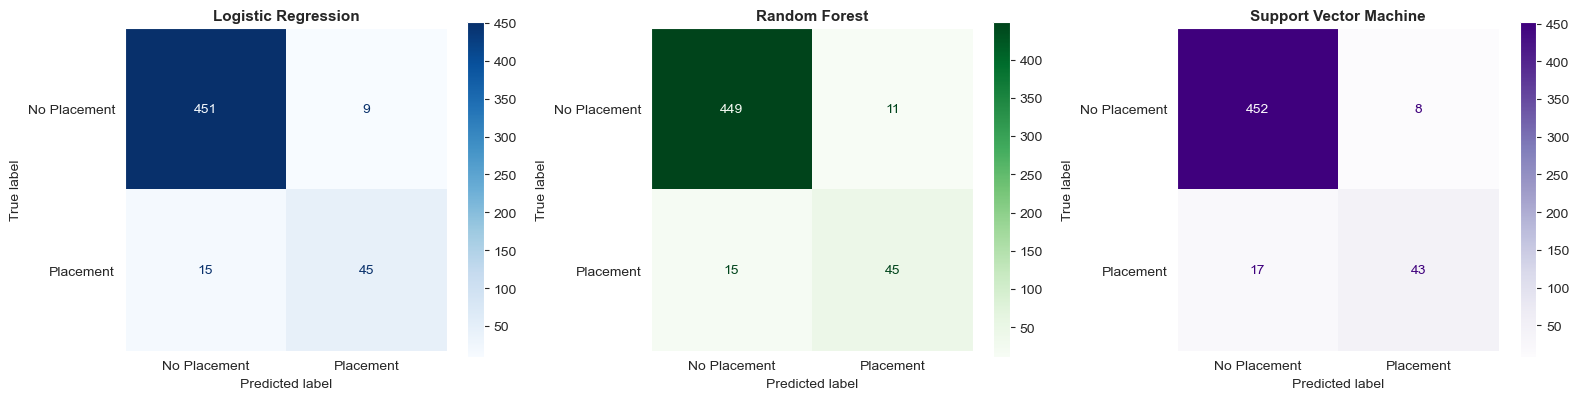

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))

ConfusionMatrixDisplay.from_predictions(y_test_b, preds_log_b, display_labels=['No Placement', 'Placement'], cmap = 'Blues', ax=ax[0]);
ConfusionMatrixDisplay.from_predictions(y_test_b, preds_rf_b, display_labels=['No Placement', 'Placement'], cmap = 'Greens', ax=ax[1]);
ConfusionMatrixDisplay.from_predictions(y_test_b, preds_svc_b, display_labels=['No Placement', 'Placement'], cmap = 'Purples', ax=ax[2]);

plt.tight_layout()
ax[0].set_title('Logistic Regression', fontweight='bold', fontsize=11)
ax[1].set_title('Random Forest', fontweight='bold', fontsize=11)
ax[2].set_title('Support Vector Machine', fontweight='bold', fontsize=11);

ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False);

In [ ]:
print(f'\n------------------- {b1}Binary Logistic{b0} ------------------ \n {classification_report(y_test_b, preds_log_b, digits=4)} \n')
print(f'---------------------- {b1}Binary RF{b0} ---------------------- \n  {classification_report(y_test_b, preds_rf_b, digits=4)} \n')
print(f'---------------------- {b1}Binary SVC{b0} --------------------- \n  {classification_report(y_test_b, preds_svc_b, digits=4)}')


------------------- Binary Logistic ------------------ 
               precision    recall  f1-score   support

           0     0.9678    0.9804    0.9741       460
           1     0.8333    0.7500    0.7895        60

    accuracy                         0.9538       520
   macro avg     0.9006    0.8652    0.8818       520
weighted avg     0.9523    0.9538    0.9528       520
 

---------------------- Binary RF ---------------------- 
                precision    recall  f1-score   support

           0     0.9677    0.9761    0.9719       460
           1     0.8036    0.7500    0.7759        60

    accuracy                         0.9500       520
   macro avg     0.8856    0.8630    0.8739       520
weighted avg     0.9487    0.9500    0.9492       520
 

---------------------- Binary SVC --------------------- 
                precision    recall  f1-score   support

           0     0.9638    0.9826    0.9731       460
           1     0.8431    0.7167    0.7748        60

  

##### <span style = 'color:mediumvioletred'> _Similar to our regression models which were able to place players generally into the Top 15 players category, these binary classification models have successfully determined whether a player will make the All-NBA Team or not with > 95% accuracy._ </span> 
    
- <span style = 'color:mediumvioletred'> _Among the players our model predicted as making an All-NBA team, we were right 84.0% of the time using SVC._ </span>
- <span style = 'color:mediumvioletred'> _Among players selected as winners, our model predicted them correctly 76.7% of the time using Random Forest._ </span>